# Predictability Study By PC

We are interested in predicting k, which is defined as the number of prefetches issued before a demand request. A sequence of k values is on a per cacheline basis. To predict k, we are interested in studying the relationship between k and features such as Program Counter and cacheline address.

### Predictability Metrics

**k distribution by top Prefetch PCs**: The distribution all k values in the top 80% most frequent prefetch trigger PCs

**Sequiter Study**: Using the compression tool Sequiter to find patterns in the distribution of k on a per PC basis

**Uniqueness Study**: The distribution of the percent of unique values of k on a per PC basis

In [2]:
import sys, re
import matplotlib as mpl
import numpy as np
import os
import subprocess
import copy
mpl.rcParams['font.size'] = 14
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import argparse

NROWS=5
NCOLS=5

In [3]:
def get_experiment_traces(experiment, trace_list):
    traces = []
    experiment_trace_files = []
    for trace in trace_list:
        trace = trace[:-1]
        traces.append(trace)
        experiment_trace = '../current_output/'+experiment+'/'+trace+'.txt'
        experiment_trace_files.append(experiment_trace)
    return (experiment_trace_files, traces)

In [4]:
def parse_ip_k_lists(trace):
    k_distr = []
    for line in open(trace, 'r'):
        if (re.match("PC:", line)):
            split = re.split(',| ', line.rstrip())
            split = [i.strip() for i in split if i.strip()]
            if (len(split) > 5):
                k_list = list(map(int, split[5:]))
                k_distr.extend(k_list)
                
    return k_distr

def search_pc_stats(trace_files):
    num_pcs = []
    for trace_file in trace_files:
        found = False
        count = [False] * 1
        for line in open(trace_file, 'r'):
            if (not count[0] and re.match('num pcs', line)):
                num_pcs.append(float(line.split()[7]))
                count[0] = True
    return num_pcs

In [5]:
def get_ip_k_list_compression(trace):
    k_compression = []
    for line in open(trace, 'r'):
        if (re.match("PC:", line)):
            split = re.split(',| ', line.rstrip())
            split = [i.strip() for i in split if i.strip()]
            if (len(split) > 5):
                k_list = split[5:]
                k_str = ""
                for k in k_list:
                    if (len(k_str) >= 120000):
                        break
                    k_str += str(k)
                output = subprocess.check_output(f'echo -n "{k_str}" | ../sequitur/c++/sequitur -p', shell=True, stderr=subprocess.STDOUT)
                output_str = str(output)
                output_split = re.split('->', output_str)
                k_compression.append(len(output_split) - 1)
    return k_compression

In [6]:
def get_ip_k_list_unique(trace):
    k_percent_unique_distr = []
    for line in open(trace, 'r'):
        if (re.match("PC:", line)):
            split = re.split(',| ', line.rstrip())
            split = [i.strip() for i in split if i.strip()]
            if (len(split) > 5):
                k_list = k_list = list(map(int, split[5:]))
                unique_k_list = set(k_list)
                k_percent_unique_distr.append(float(len(unique_k_list) / float(len(k_list)))*100.0)
    return k_percent_unique_distr

In [7]:
def graph_k_distr(experiment_trace_files, traces):
    fig = plt.figure(figsize=(30, 30))
    spec = gridspec.GridSpec(nrows = NROWS, ncols = NCOLS, wspace = 0.2, hspace = 0.4)
    axs = []
    i = 0
    
    for r in range(NROWS):
        for c in range(NCOLS):
            ax = fig.add_subplot(spec[r, c])
            ax.set_ylabel('Frequency')
            ax.set_xlabel('k')
            if (i < len(traces)):
                ax.set_title(f'{traces[i]} k distribution')
            axs.append(ax)
            i += 1

    i = 0
    for trace in experiment_trace_files:
        k_distr = parse_ip_k_lists(trace)
        bins = 10
        if (len(k_distr) != 0):
            bins = max(k_distr) - min(k_distr)
            if (bins == 0):
                bins = 10
        if (i < len(traces)):
            axs[i].hist(k_distr, bins=bins, rwidth=0.8)
        i += 1

In [8]:
def graph_k_compression(experiment_trace_files, traces):
    fig = plt.figure(figsize=(30, 30))
    spec = gridspec.GridSpec(nrows = NROWS, ncols = NCOLS, wspace = 0.2, hspace = 0.4)
    axs = []
    
    i = 0
    for r in range(NROWS):
        for c in range(NCOLS):
            ax = fig.add_subplot(spec[r, c])
            ax.set_ylabel('Frequency')
            ax.set_xlabel('compressability factor')
            if (i < len(traces)):
                ax.set_title(f'{traces[i]} k compressability')
            axs.append(ax)
            i += 1
    i = 0
    for trace in experiment_trace_files:
        k_compression = get_ip_k_list_compression(trace)
        bins = 10
        if (len(k_compression) != 0):
            bins = max(k_compression) - min(k_compression)
            if (bins == 0):
                bins = 10
        if (i < len(traces)):
            axs[i].hist(k_compression, bins=bins, rwidth=0.8)
        i += 1

In [9]:
def graph_k_percent_unique(experiment_trace_files, traces):
    fig = plt.figure(figsize=(30, 30))
    spec = gridspec.GridSpec(nrows = NROWS, ncols = NCOLS, wspace = 0.2, hspace = 0.4)
    axs = []
    
    i = 0
    for r in range(NROWS):
        for c in range(NCOLS):
            ax = fig.add_subplot(spec[r, c])
            ax.set_ylabel('Frequency')
            ax.set_xlabel('Percent Unique')
            if (i < len(traces)):
                ax.set_title(f'{traces[i]} k percent unique')
            axs.append(ax)
            i += 1
    i = 0
    for trace in experiment_trace_files:
        k_unique = get_ip_k_list_unique(trace)
        bins = 20
        if (i < len(traces)):
            axs[i].hist(k_unique, bins=bins, rwidth=0.8)
        i += 1

In [10]:
def add_data_labels(bar, ax, labels):
    rects = bar.patches
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom")
        
def mean(data):
    total = 0
    count = 0
    for x in data:
        if (not np.isnan(x)):
            total += x
        else:
            total += 0
        count += 1
    return  round(float(total/count), 2)
def add_mean(data):
    data.append(mean(data))
    return data

In [11]:
def graph_pc_stats(experiment_trace_files, traces):
    fig, ax = plt.subplots()
    # get num pcs
    num_pcs = search_pc_stats(experiment_trace_files)
    num_pcs = add_mean(num_pcs)
    
    # format x axis
    ind = np.arange(0, len(traces) + 1, 1)
    traces_with_mean = copy.deepcopy(traces)
    traces_with_mean.append('zz_mean')
    ax.set_xticks(np.arange(0, len(traces) + 1, 1))
    ax.set_xticklabels(traces_with_mean, rotation = 45, ha='right')
    
    # plot num pcs
    bar = ax.bar(traces_with_mean, num_pcs, width=0.5)
    
    # add data labels
    add_data_labels(bar, ax, num_pcs)
    
    # axis label and title formatting
    ax.set_title('number of prefetch PCs to reach top 80% frequency')
    ax.set_xlabel('benchmarks')
    ax.set_ylabel('number of PCs')
    
    # figure width and height
    fig.set_figwidth(30)
    fig.set_figheight(15)

## Harmony with Best Offset Prefetcher K Predictability Study

There are four studies below:
1. Prefetch PC Frequency
2. k distribution by top Prefetch PCs

3. Sequiter Study

4. Uniqueness Study 

### Harmony with Best Offset Prefetch PC Frequency Study

This study calculates the frequency of each prefetch PC and ranks them in decending order, and graphs the top n PCs to reach 80% of all prefetch accesses.

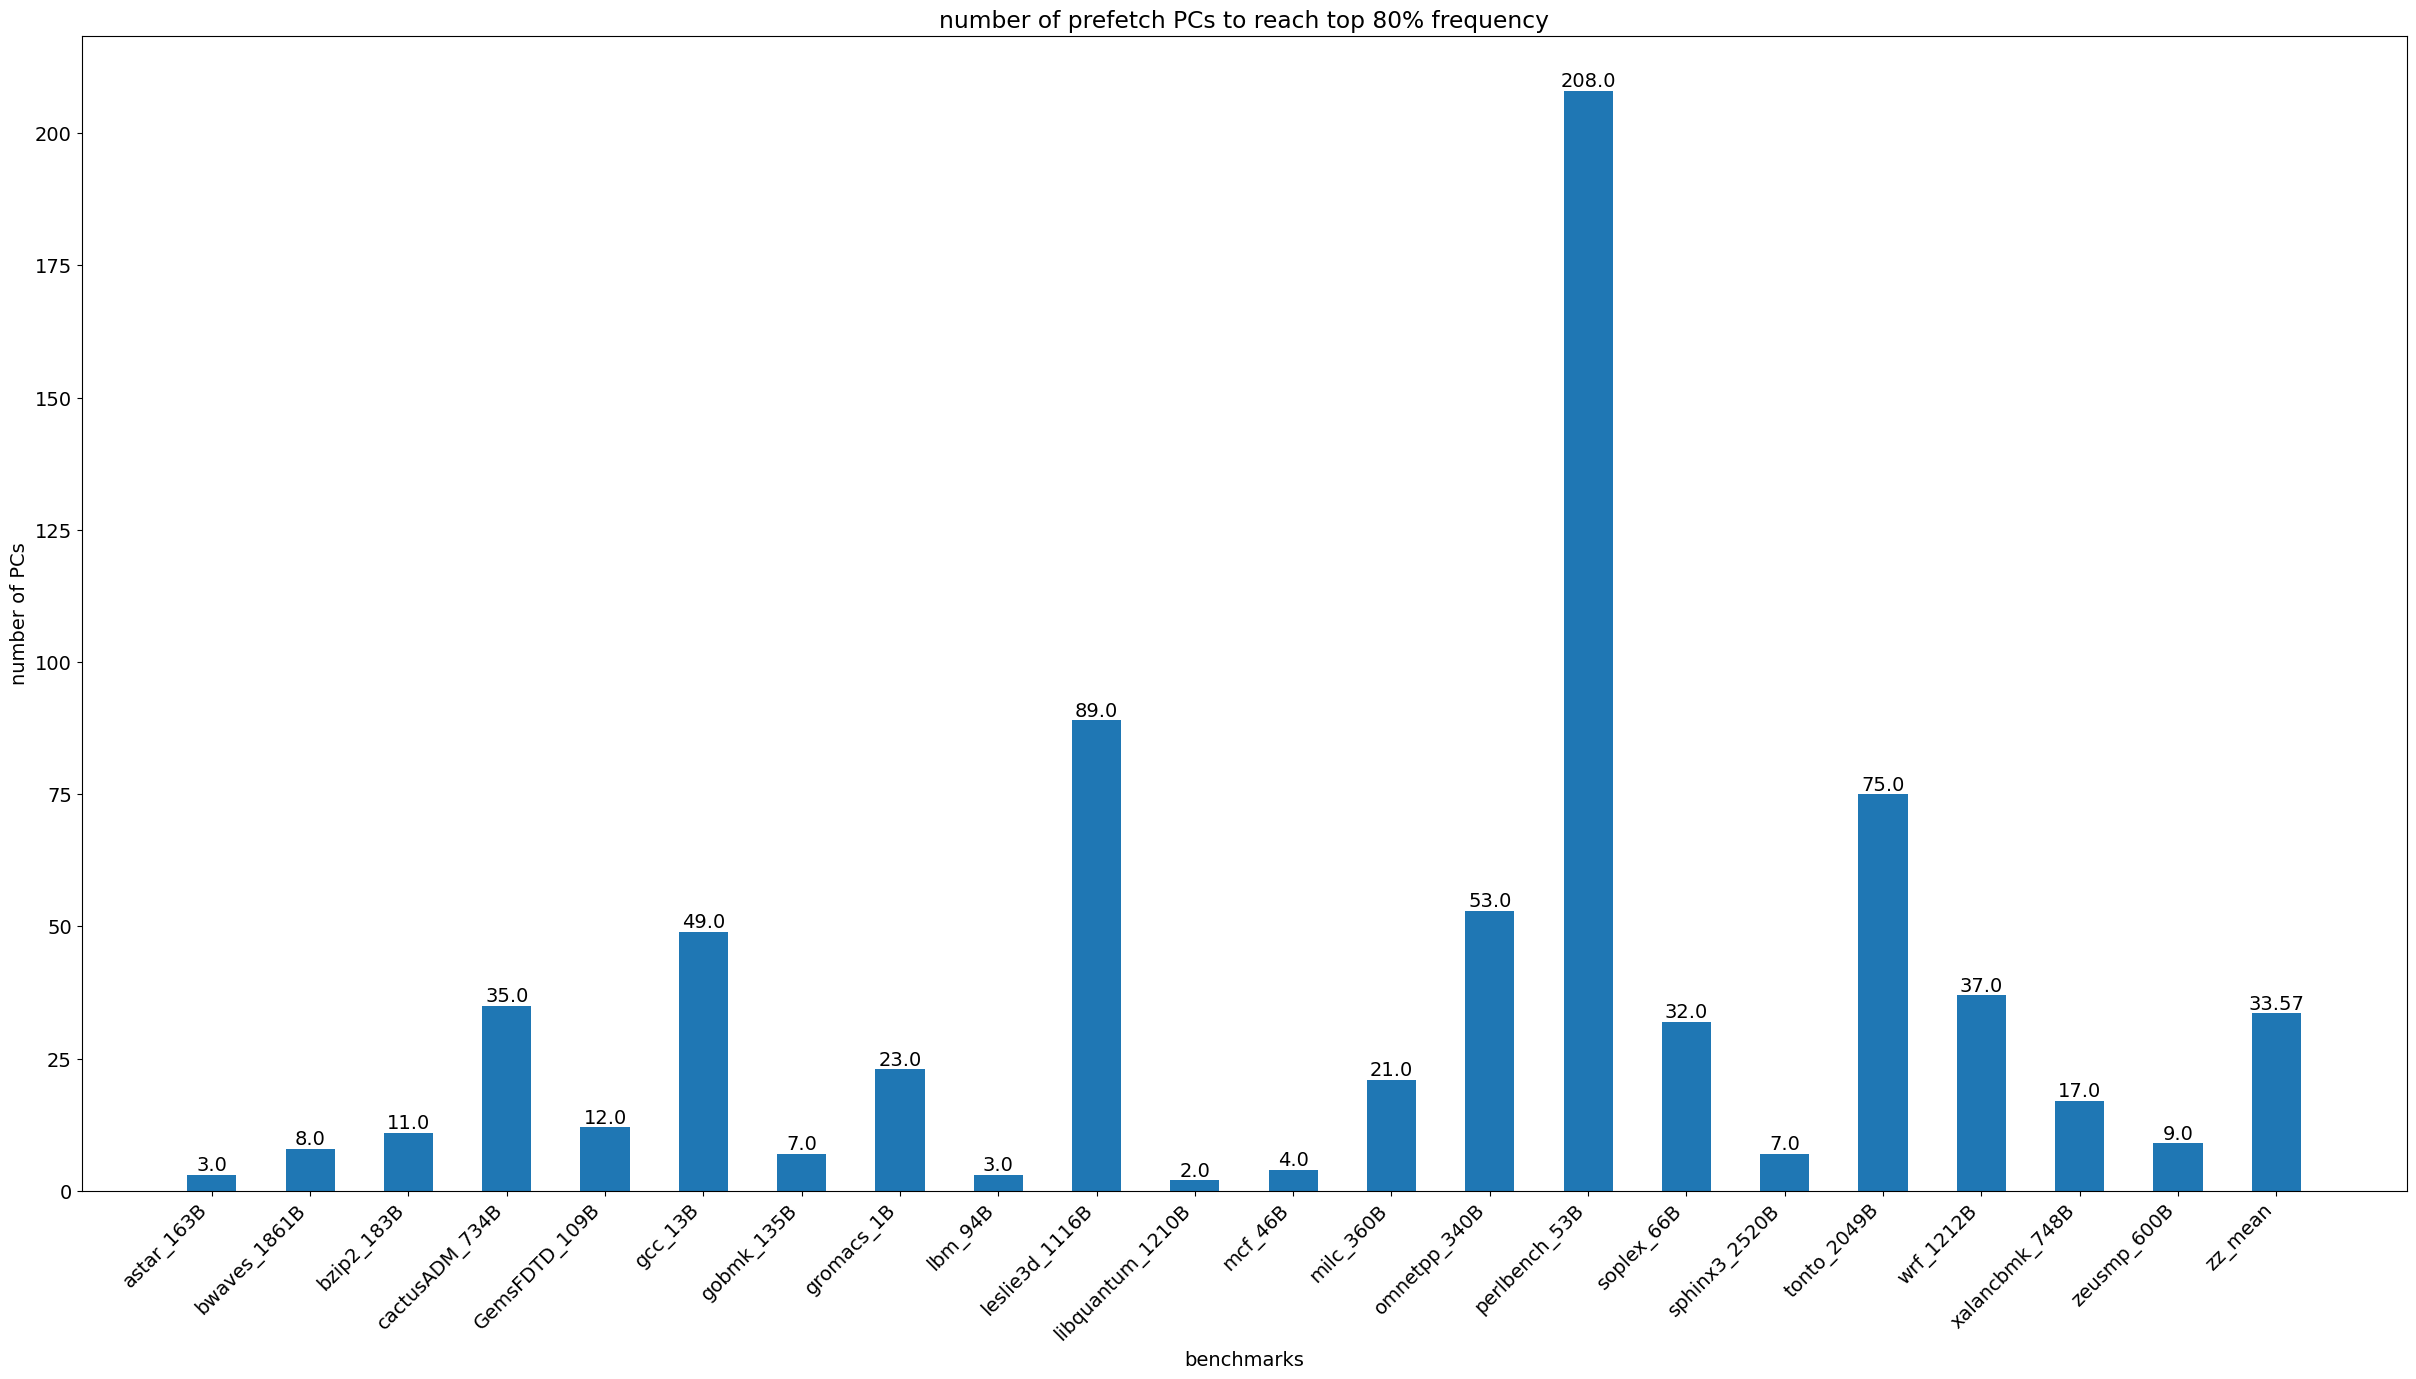

In [13]:
# Harmony with Best Offset Prefetch Interval Use
# get experiment trace files
experiment = 'experiment_tracer_hawkeye_final_dyn_bo_pc_freq_prefetch_ip_k_list'
trace_list = open('../sim_list/traces.txt', 'r')

(experiment_trace_files, traces) = get_experiment_traces(experiment, trace_list)

graph_pc_stats(experiment_trace_files, traces)
plt.show()

### Harmony with Best Offset Prefetcher K Distribution by Top Prefetch PCs Study

This study graphs the distribution of k, the number of prefetches issued before a demand access to the cacheline, aggregated on a per PC basis for the top n PCs in the above study. The distributions show that k is mostly small and seems to follow a negative exponential distribution.

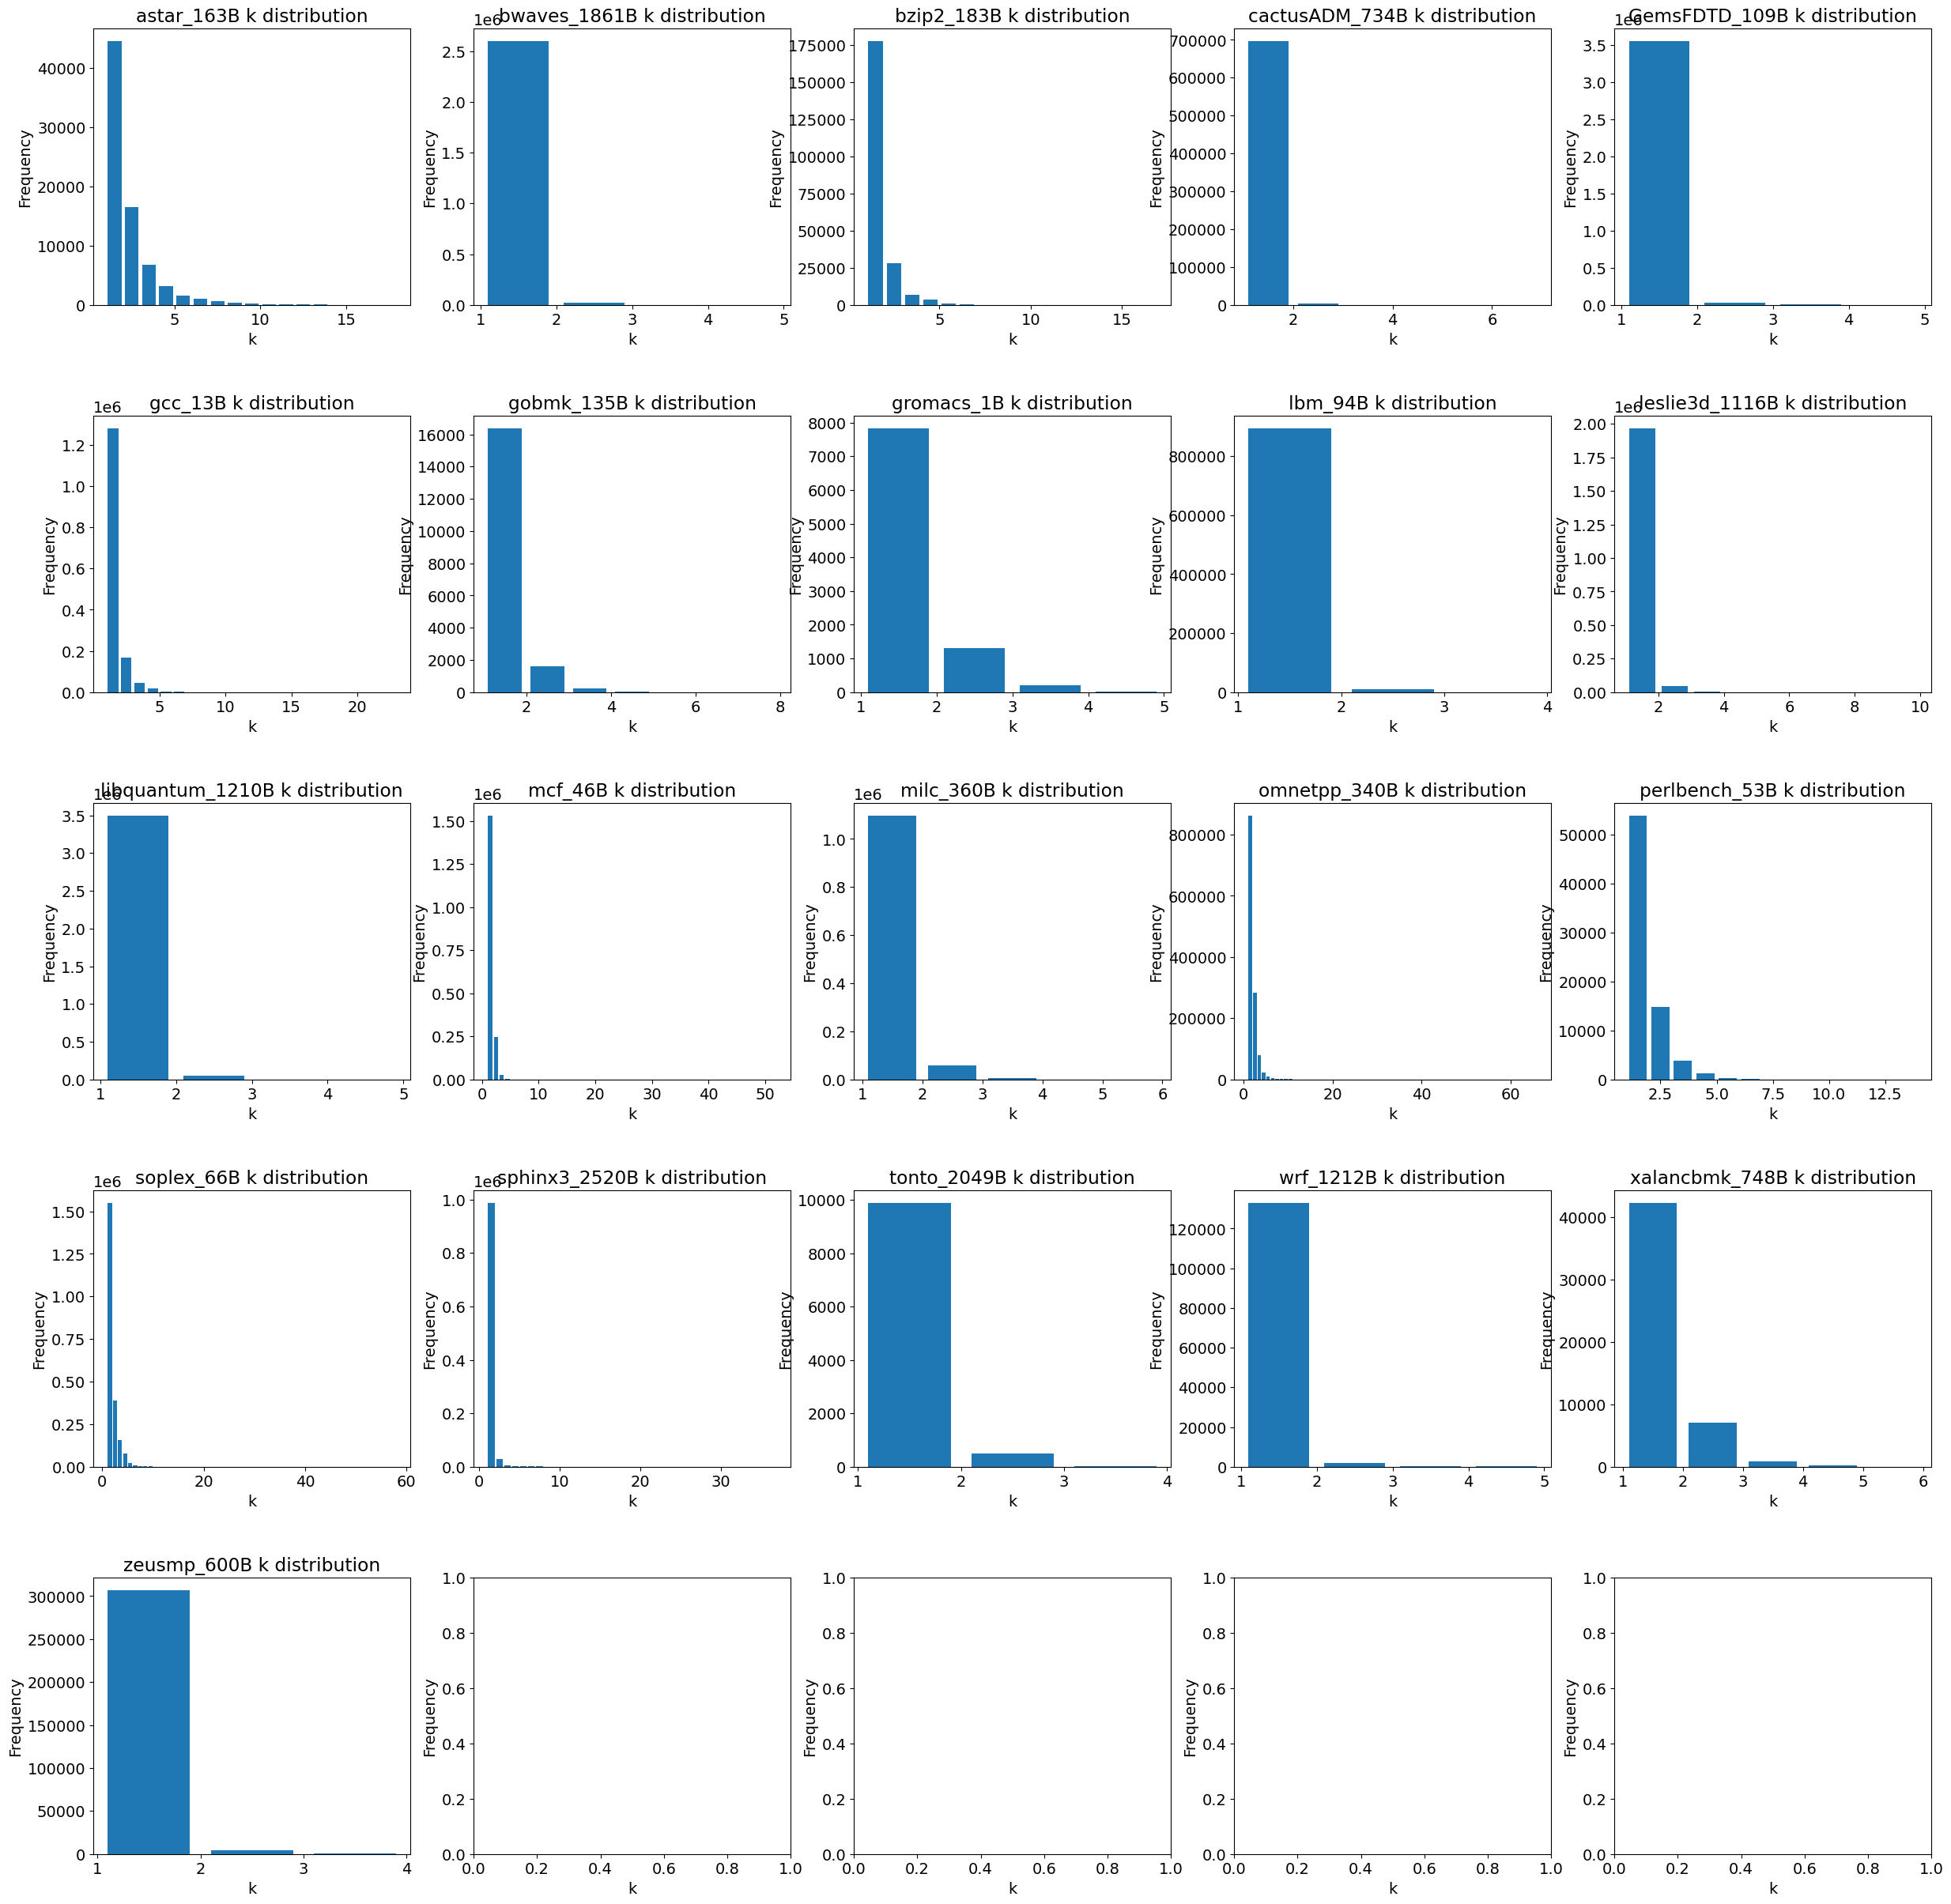

In [12]:
graph_k_distr(experiment_trace_files, traces)
plt.show()

### Harmony with Best Offset Prefetcher K Distribution Compressability

This study graphs the compressability of the k distribution aggregated by the top prefetch PCs using Sequitur. The graphs show high compressability, suggesting patterns and repeated numbers in the distribution of k.

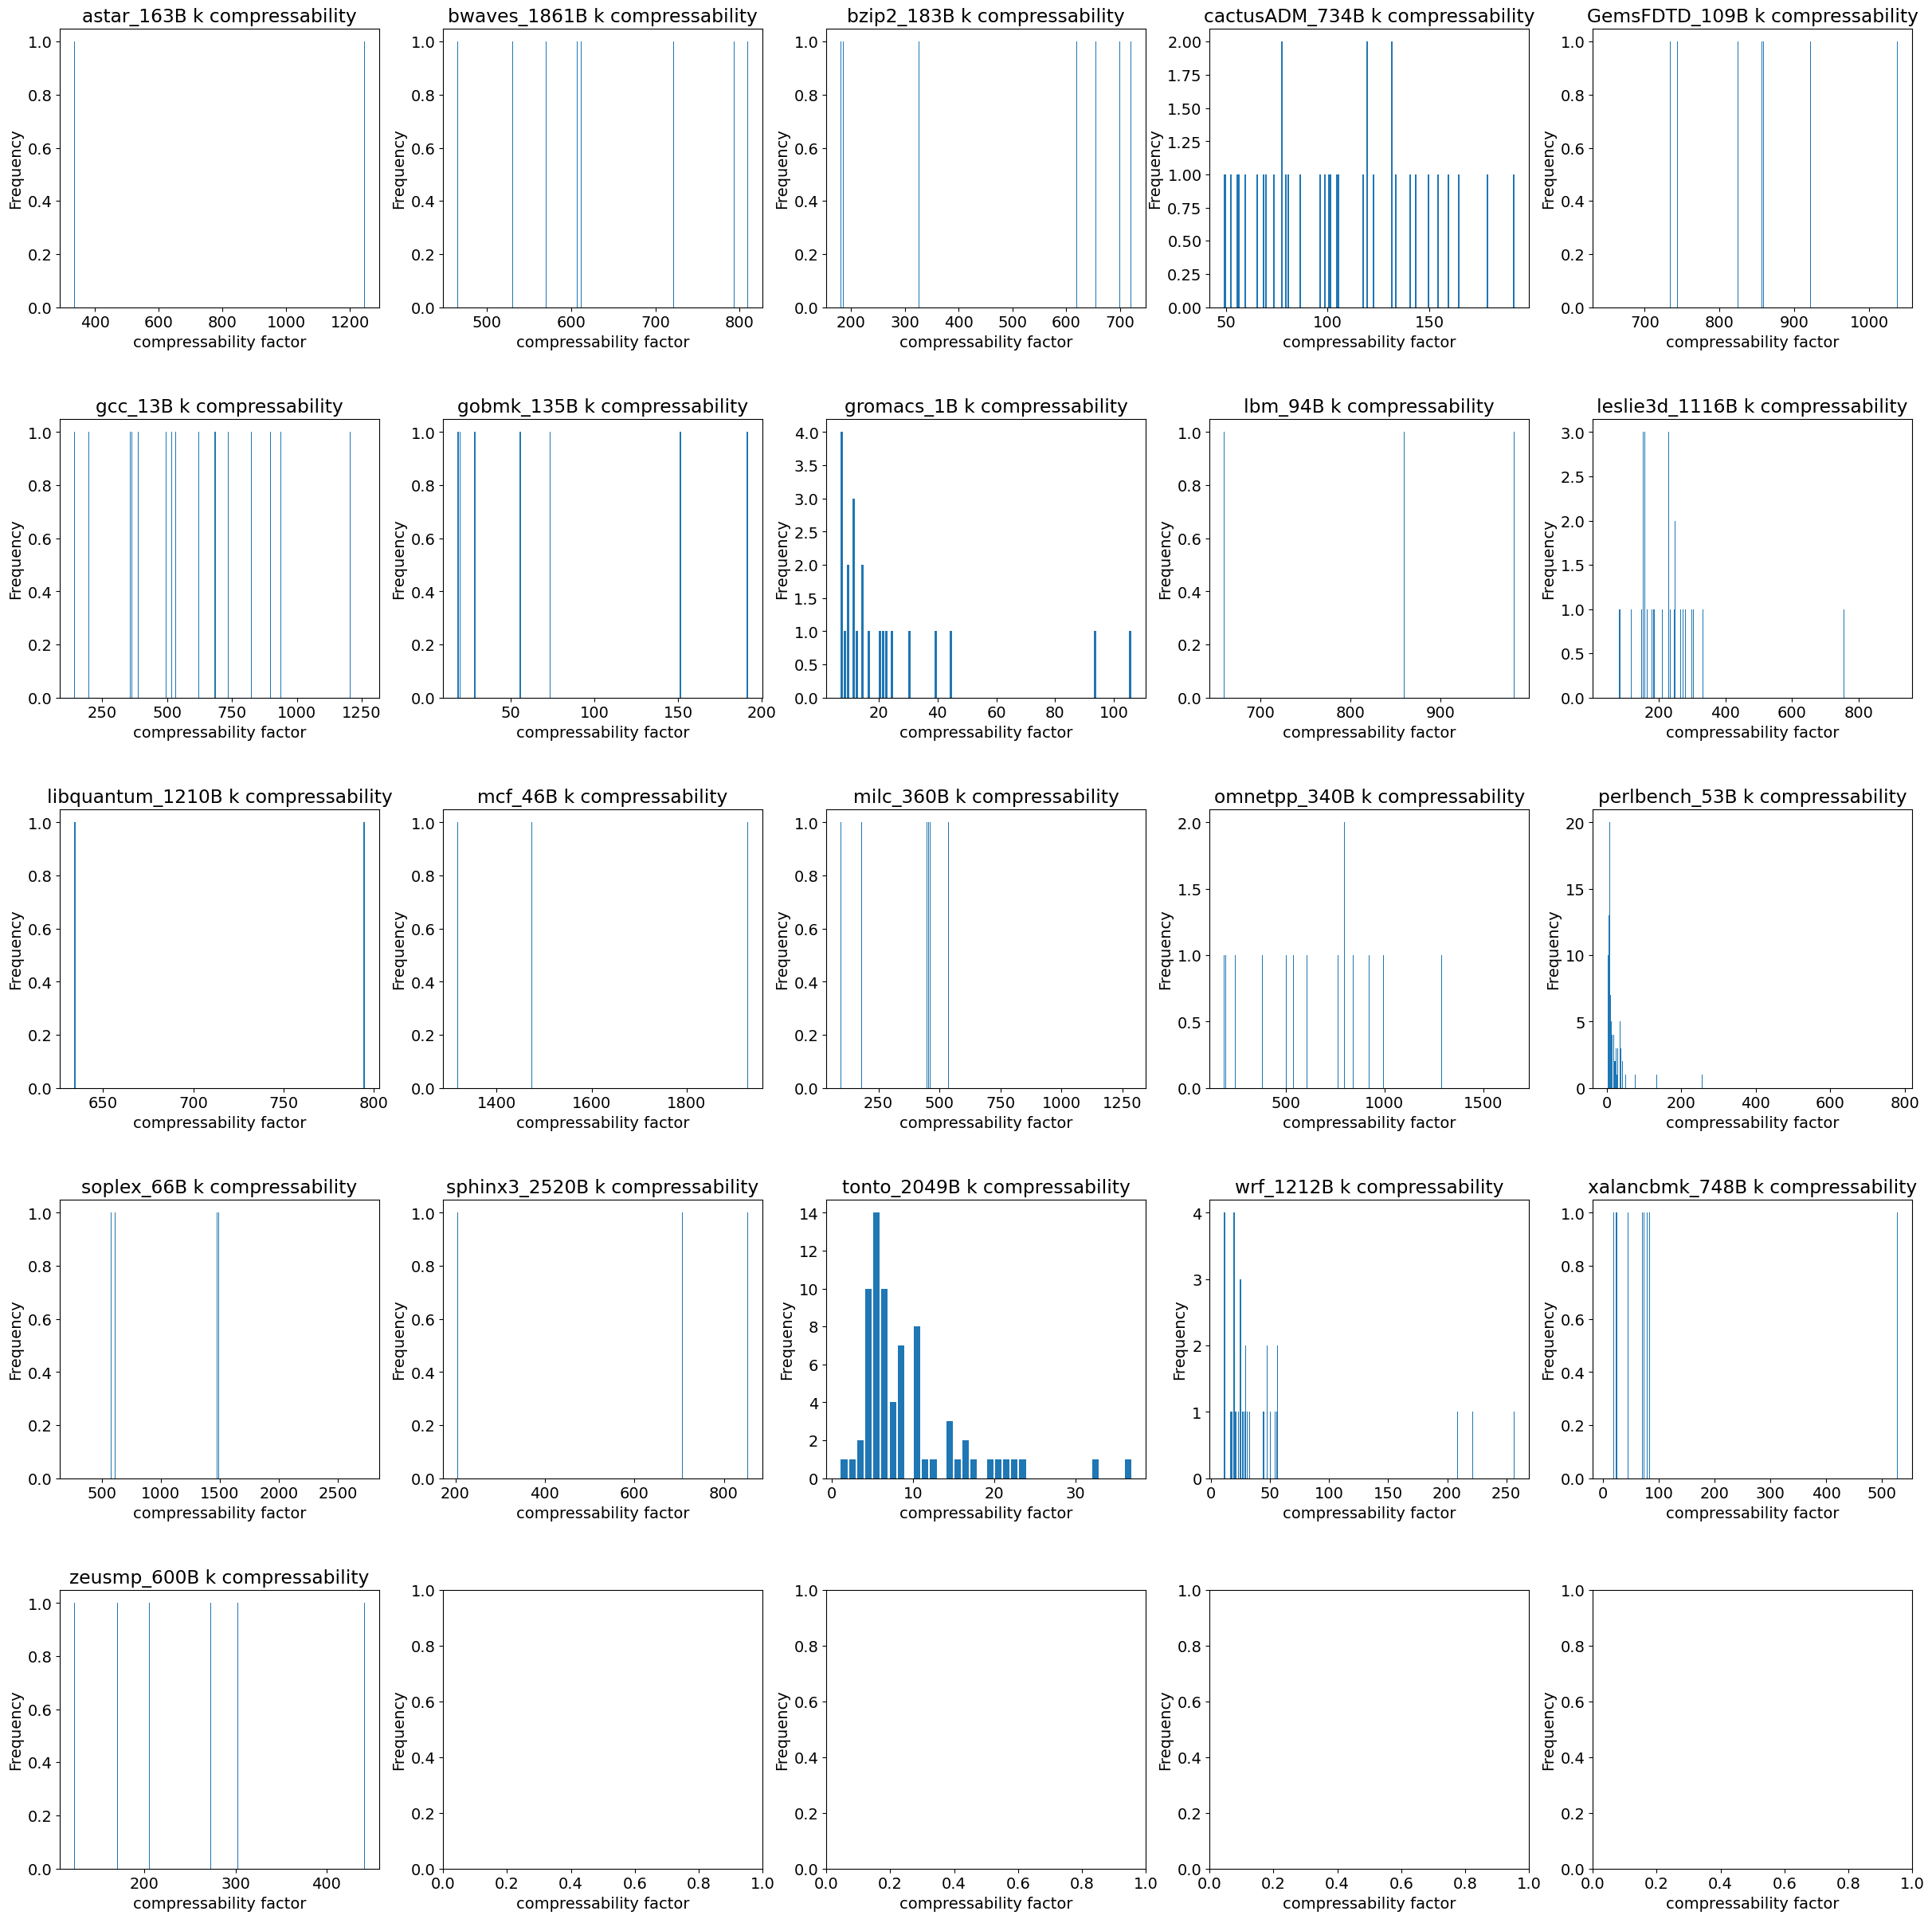

In [13]:
graph_k_compression(experiment_trace_files, traces)
plt.show()

### Harmony with Best Offset Prefetcher K Distribution Percent Unique

This study looks at the percent of unique numbers in the sequence of k values for the top prefetch PCs. Each top prefetch PC maps to a sequence of k values, and the percent of unique numbers is calculated using the size of each sequence of k values. It seems that the percent of unique values is small, suggesting significant repetition in the sequences of k values grouped by prefetch PC.

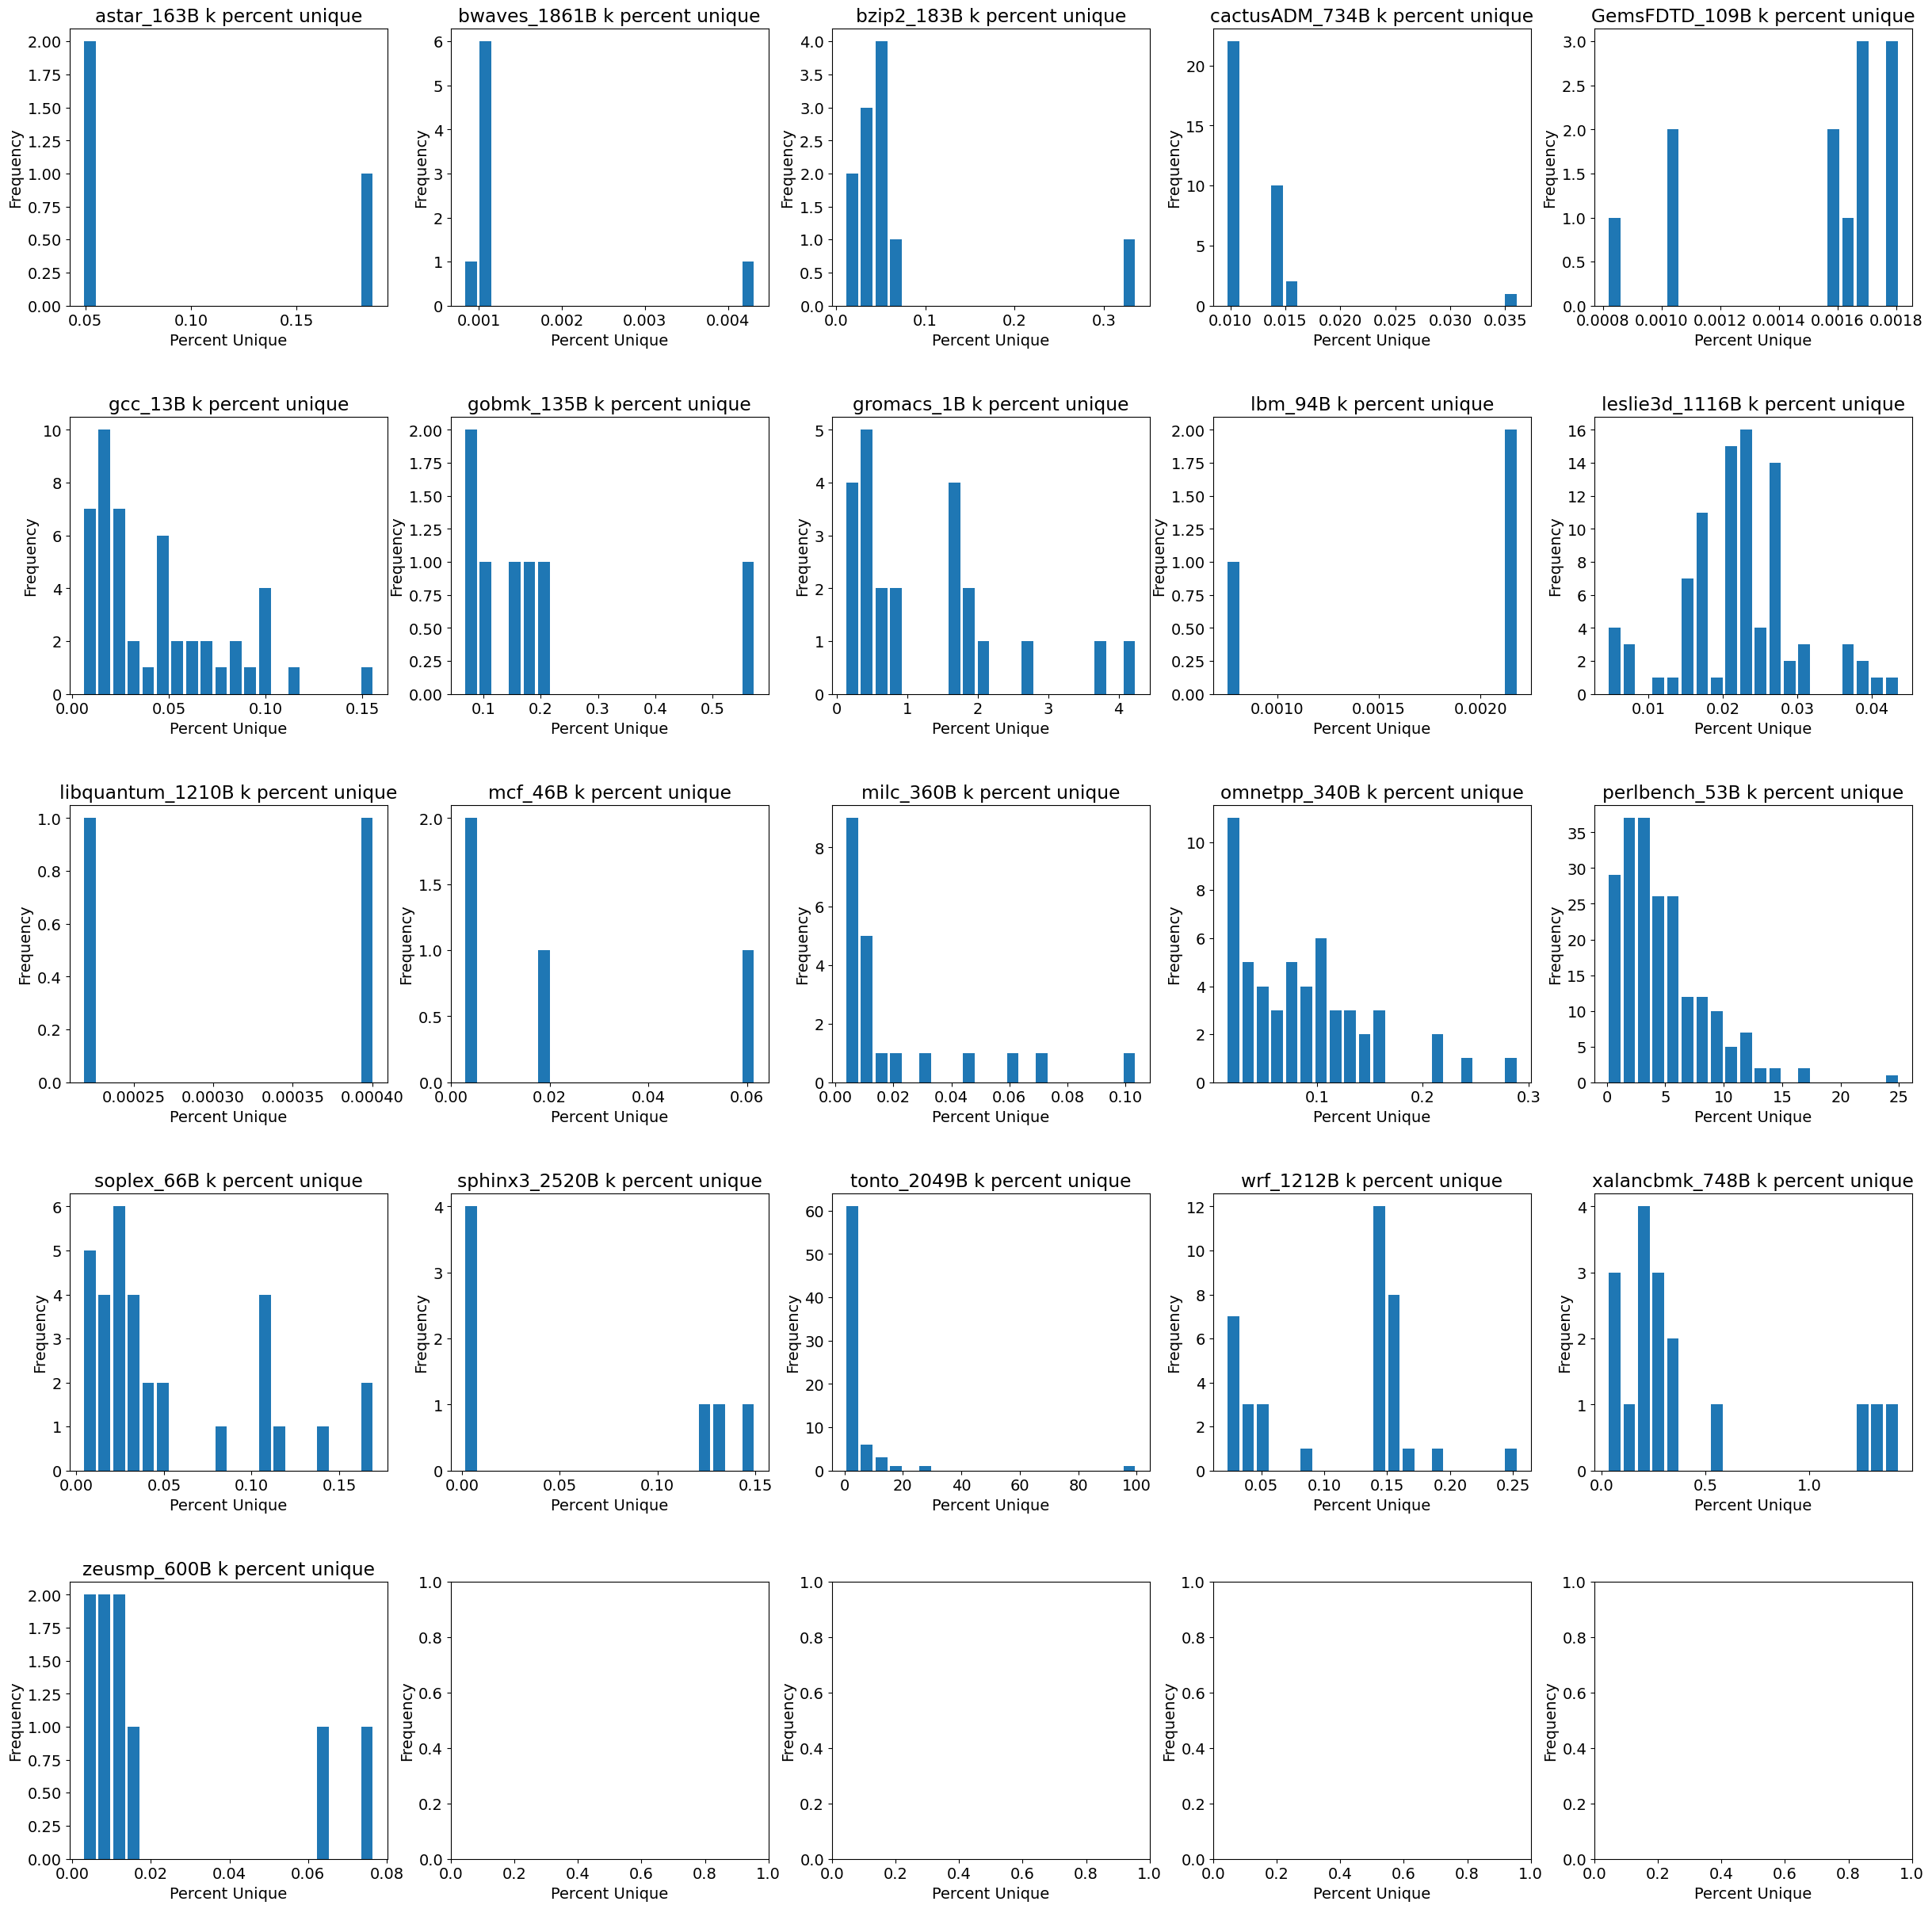

In [14]:
graph_k_percent_unique(experiment_trace_files, traces)
plt.show()

## Harmony with Best Offset Prefetcher K Predictability Study

There are four studies below:
1. Prefetch PC Frequency
2. k distribution by top Prefetch PCs

3. Sequiter Study

4. Uniqueness Study 

Like the studies for Harmony with Best Offset prefetcher, the values for k seem very predictable here as well.

### Harmony with Best Offset Prefetch PC Frequency Study

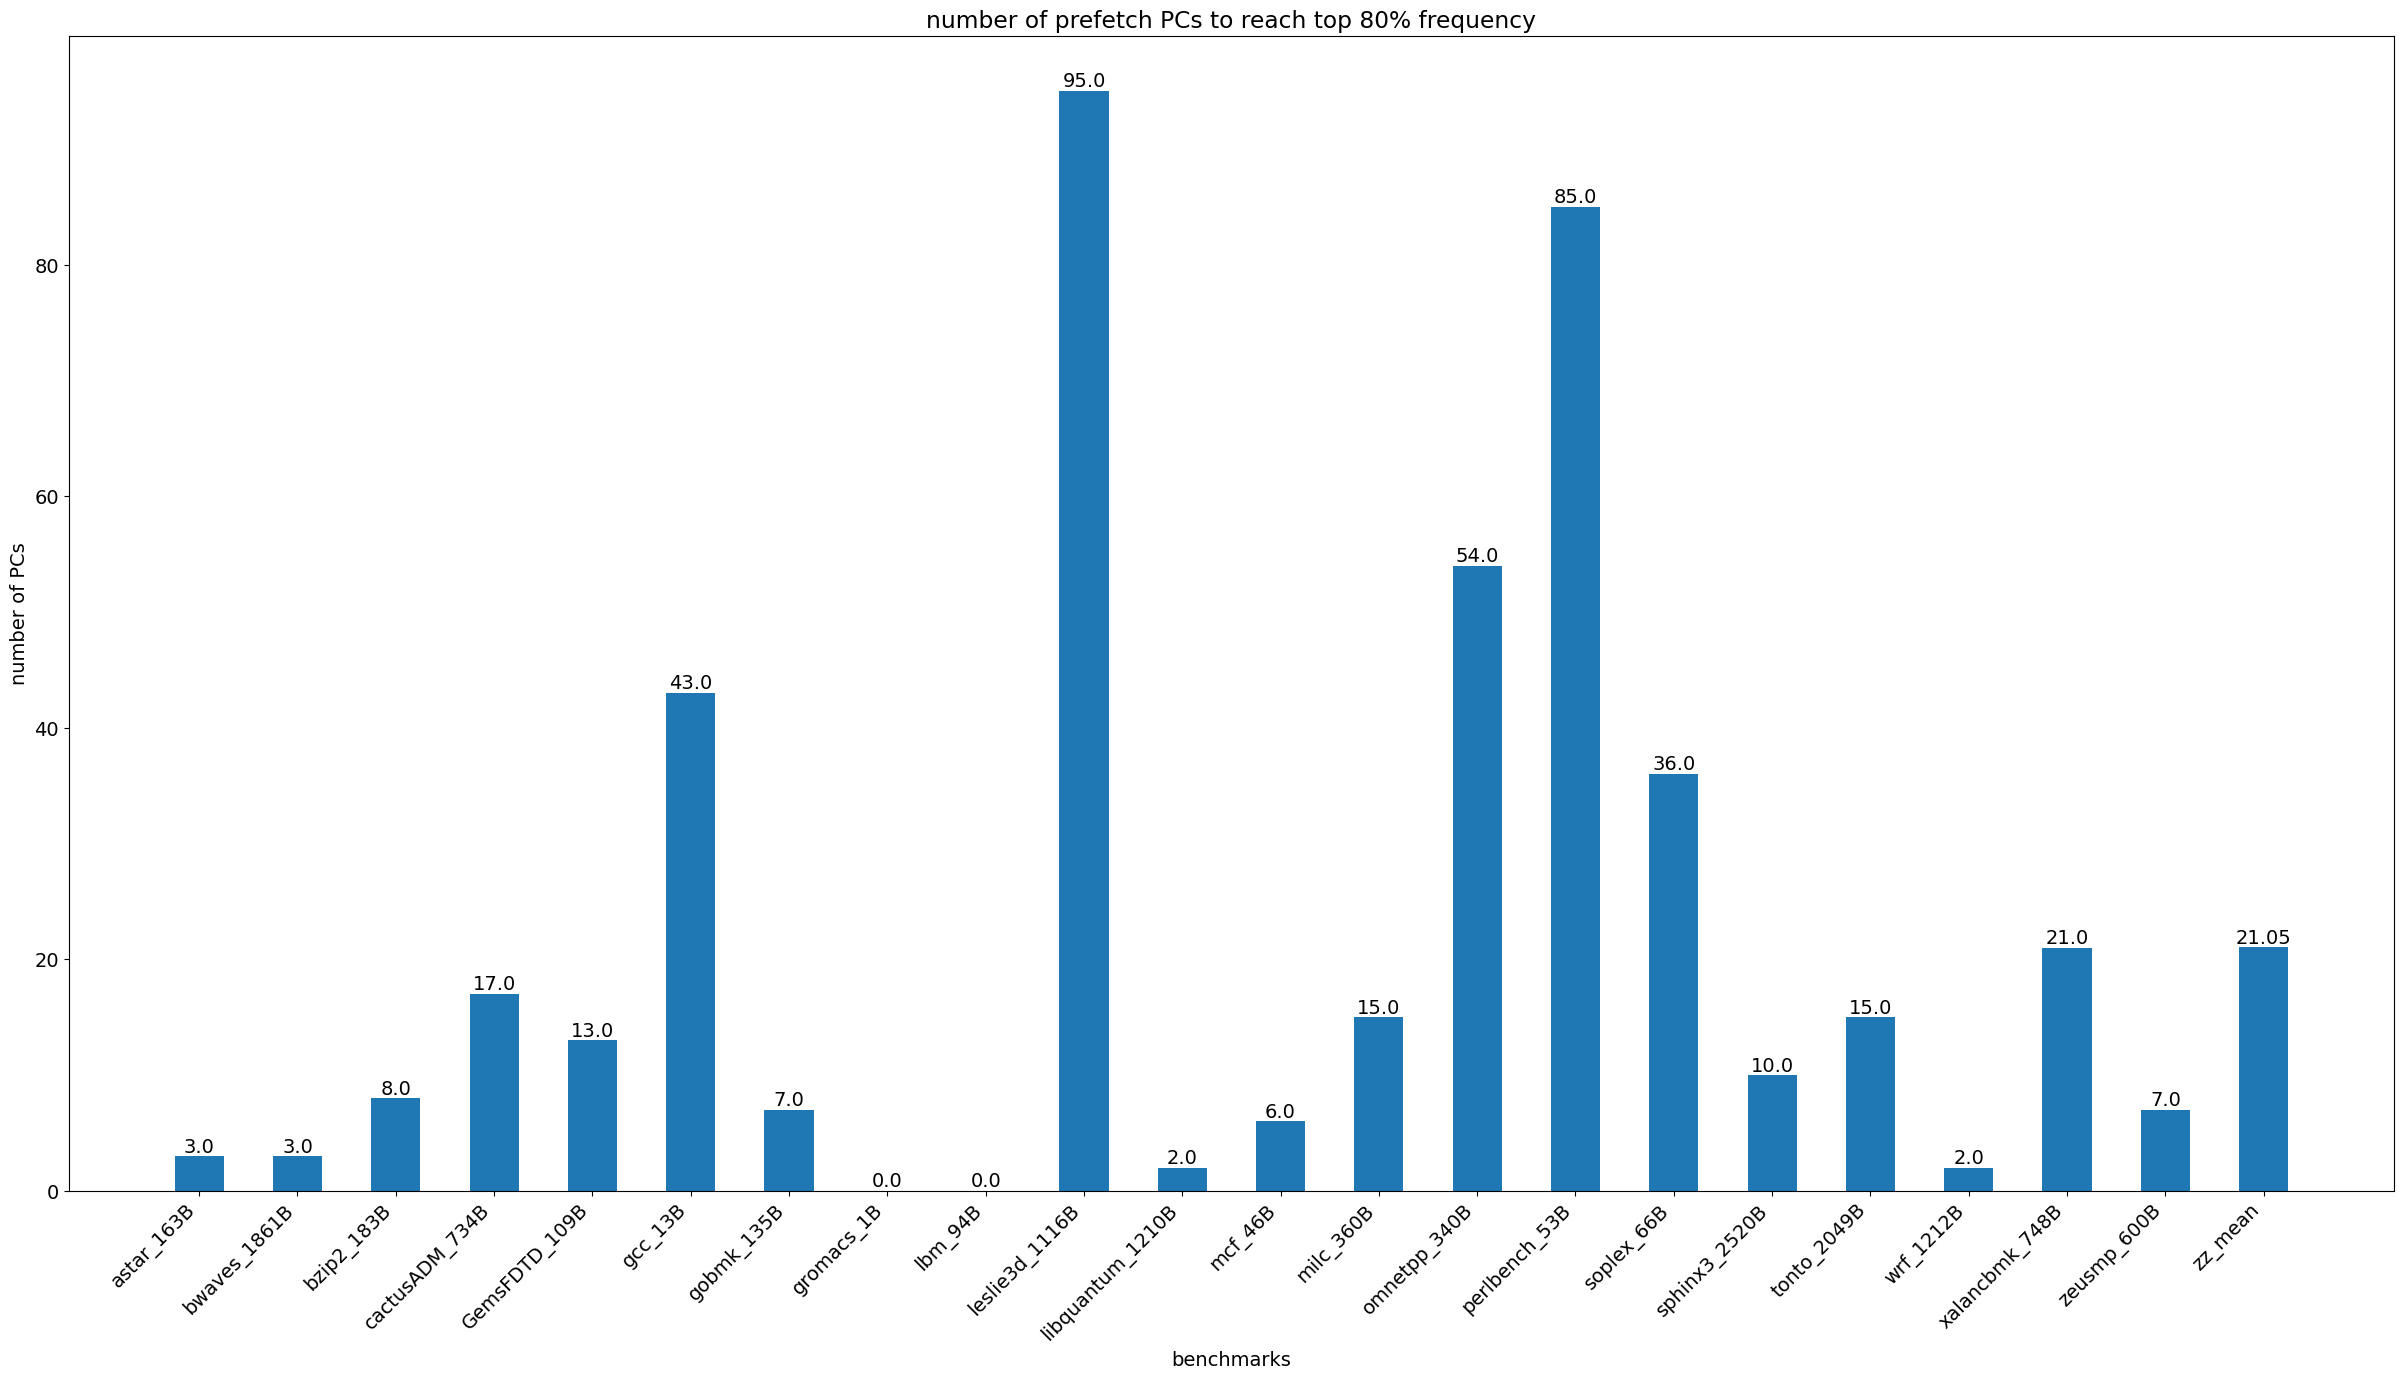

In [75]:
# Harmony with ISB Prefetch Interval Use
# get experiment trace files
experiment = 'experiment_tracer_hawkeye_final_dyn_isb_pc_freq_prefetch_ip_k_list'
trace_list = open('../sim_list/traces.txt', 'r')

(experiment_trace_files, traces) = get_experiment_traces(experiment, trace_list)

graph_pc_stats(experiment_trace_files, traces)
plt.show()

### Harmony with ISB Prefetcher K Distribution by Top Prefetch PCs Study


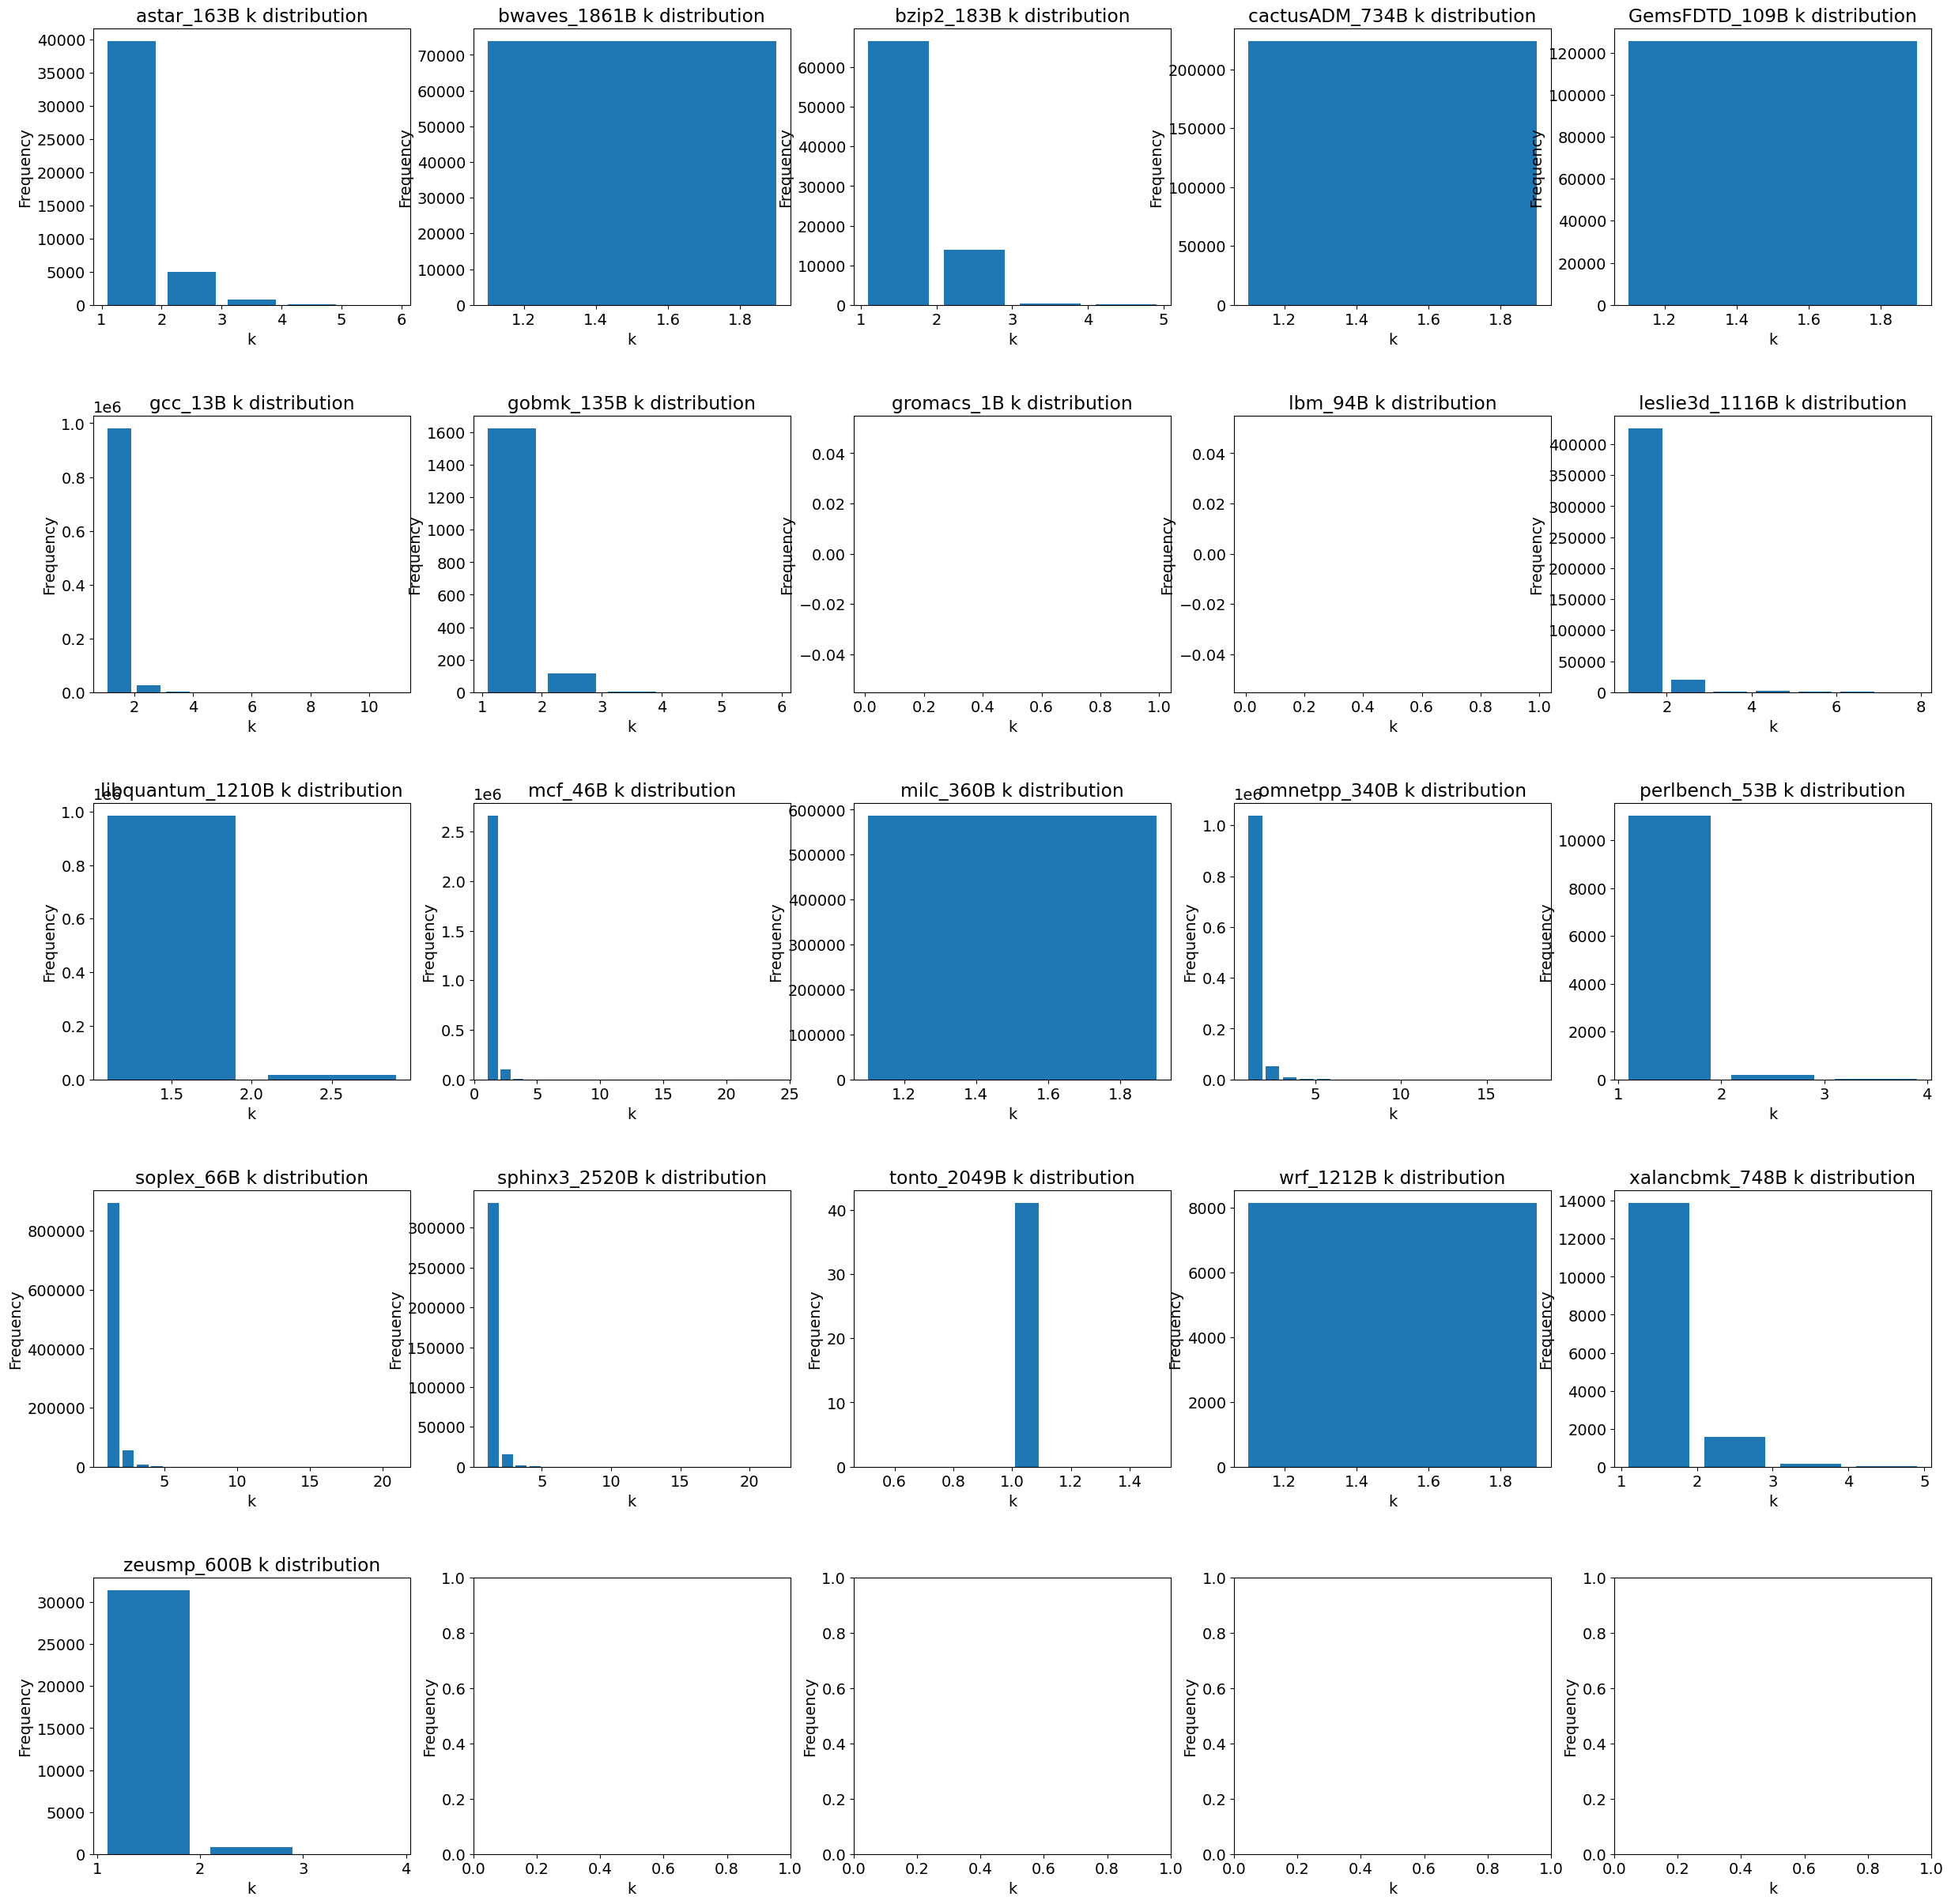

In [76]:
graph_k_distr(experiment_trace_files, traces)
plt.show()

### Harmony with ISB Prefetcher K compressability Study

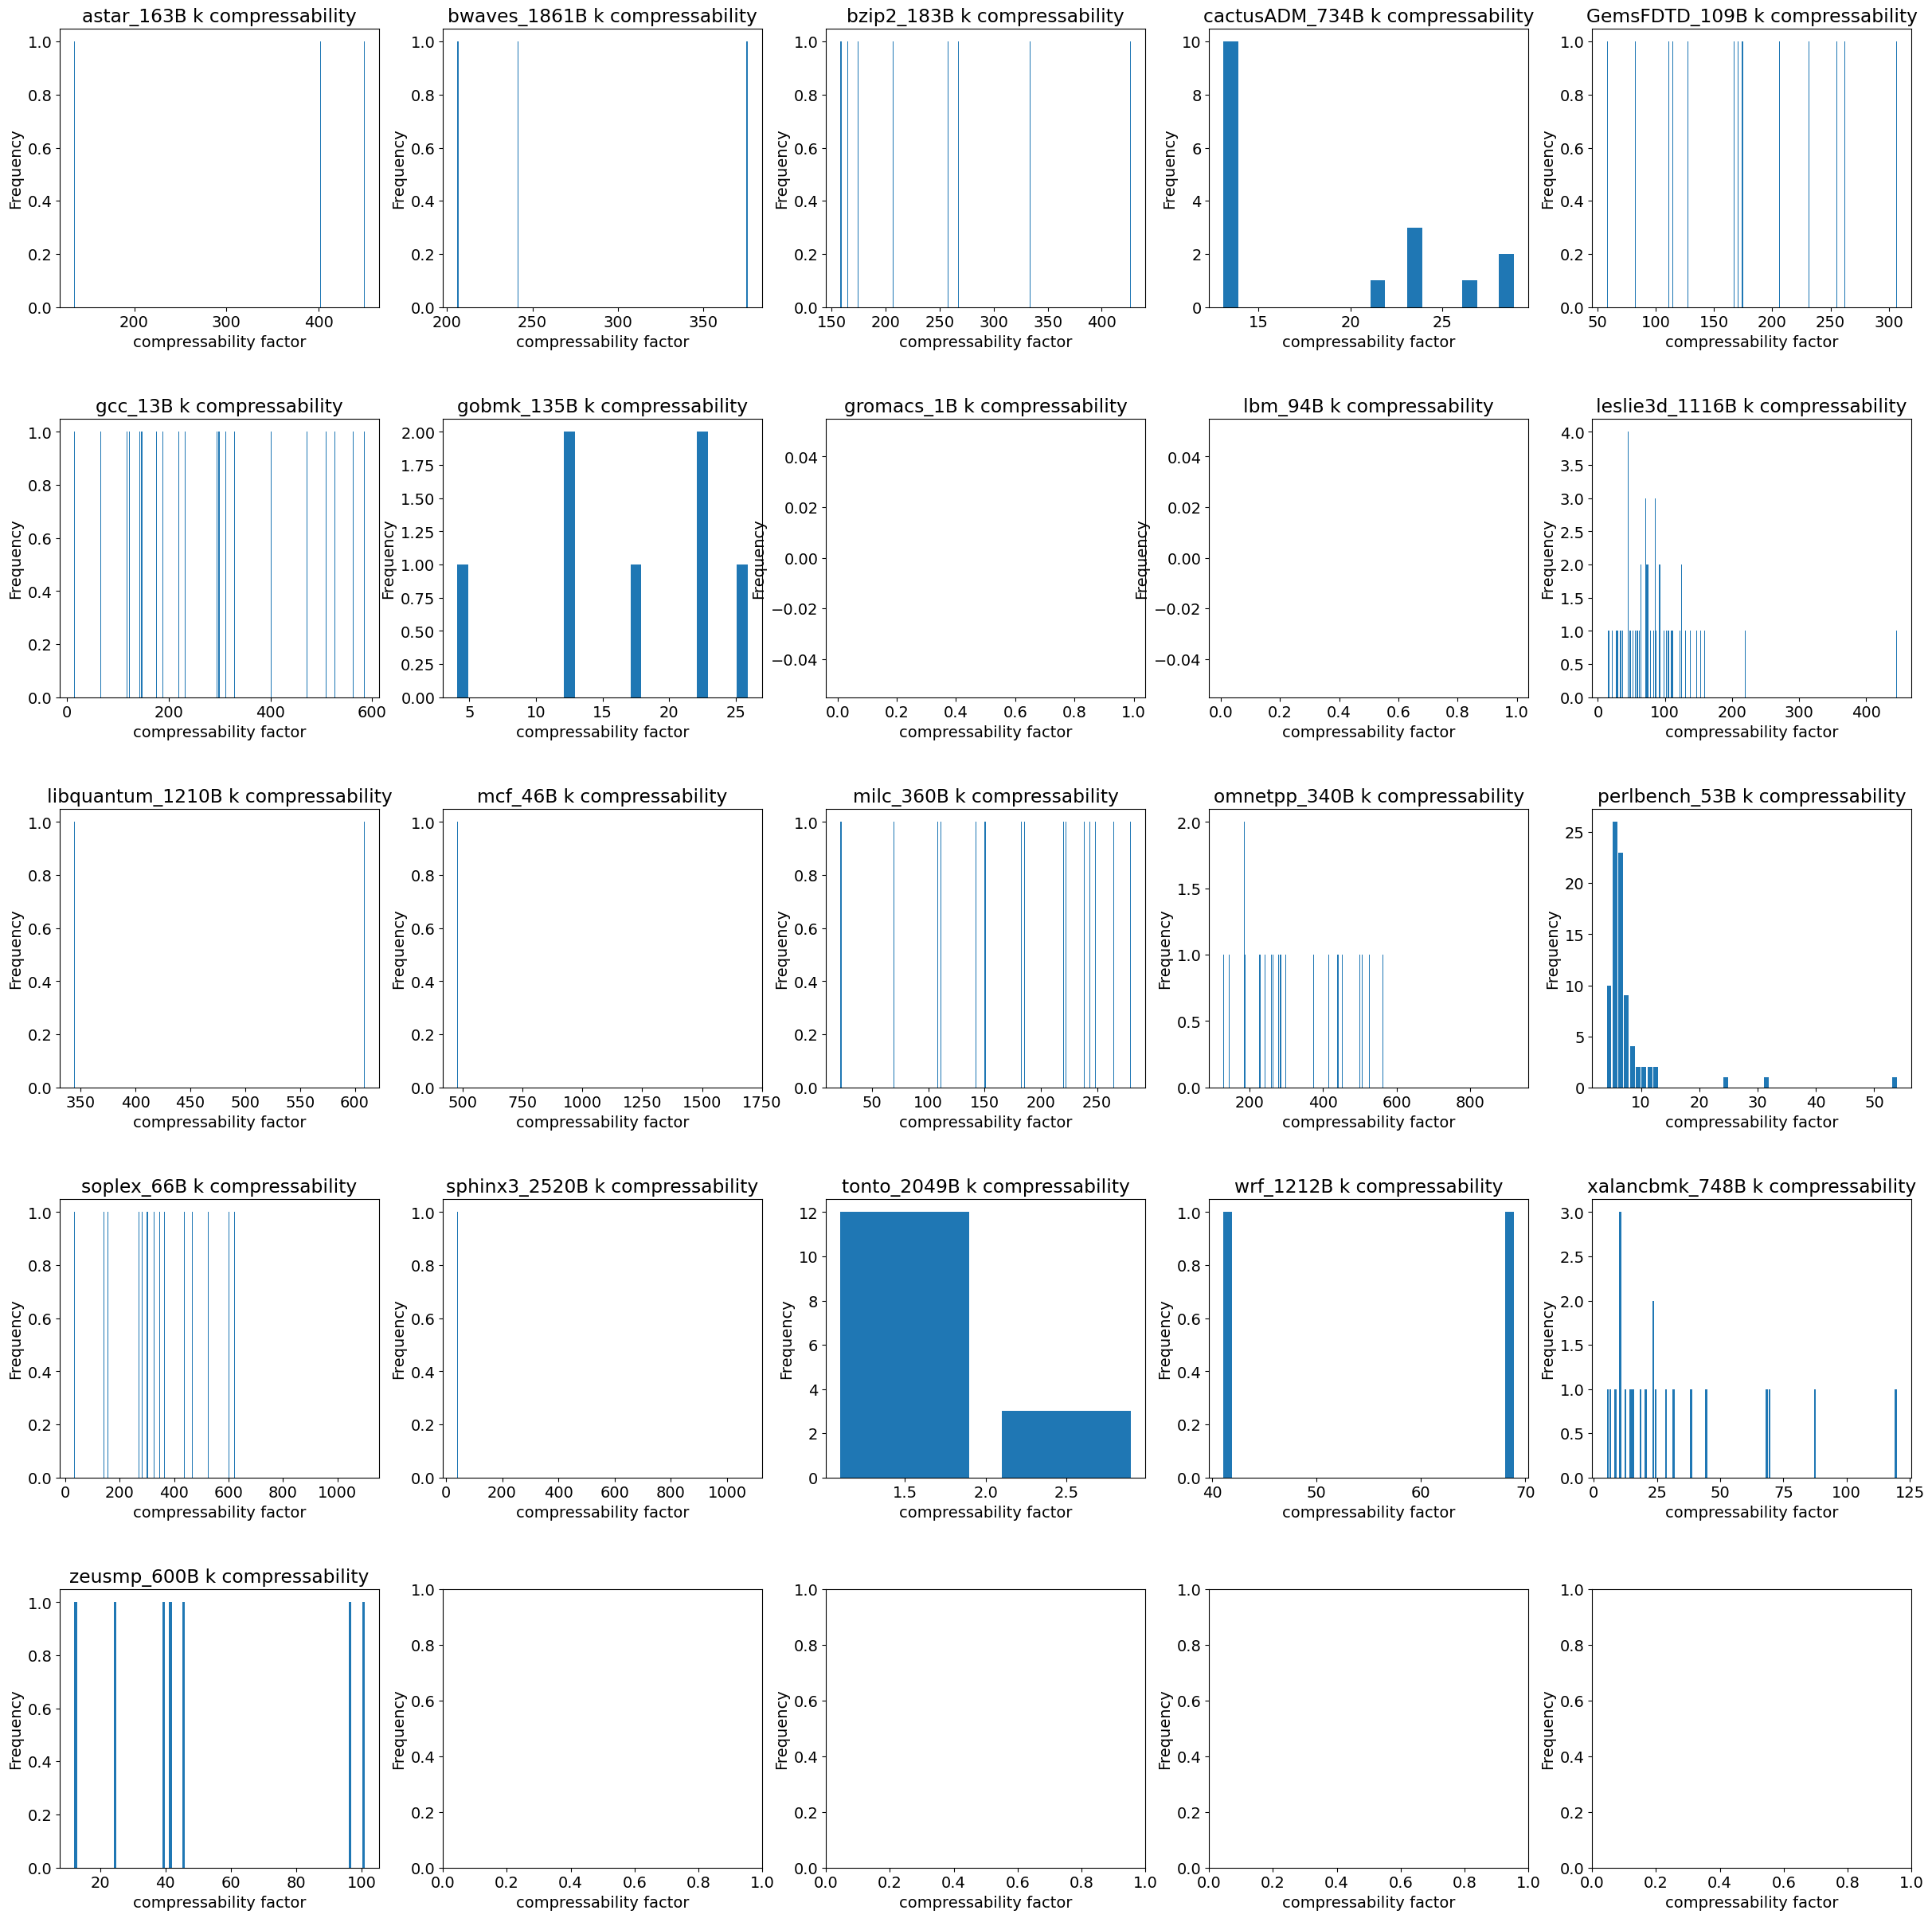

In [83]:
graph_k_compression(experiment_trace_files, traces)
plt.show()

### Harmony with ISB Prefetcher K distribution percent unique values study

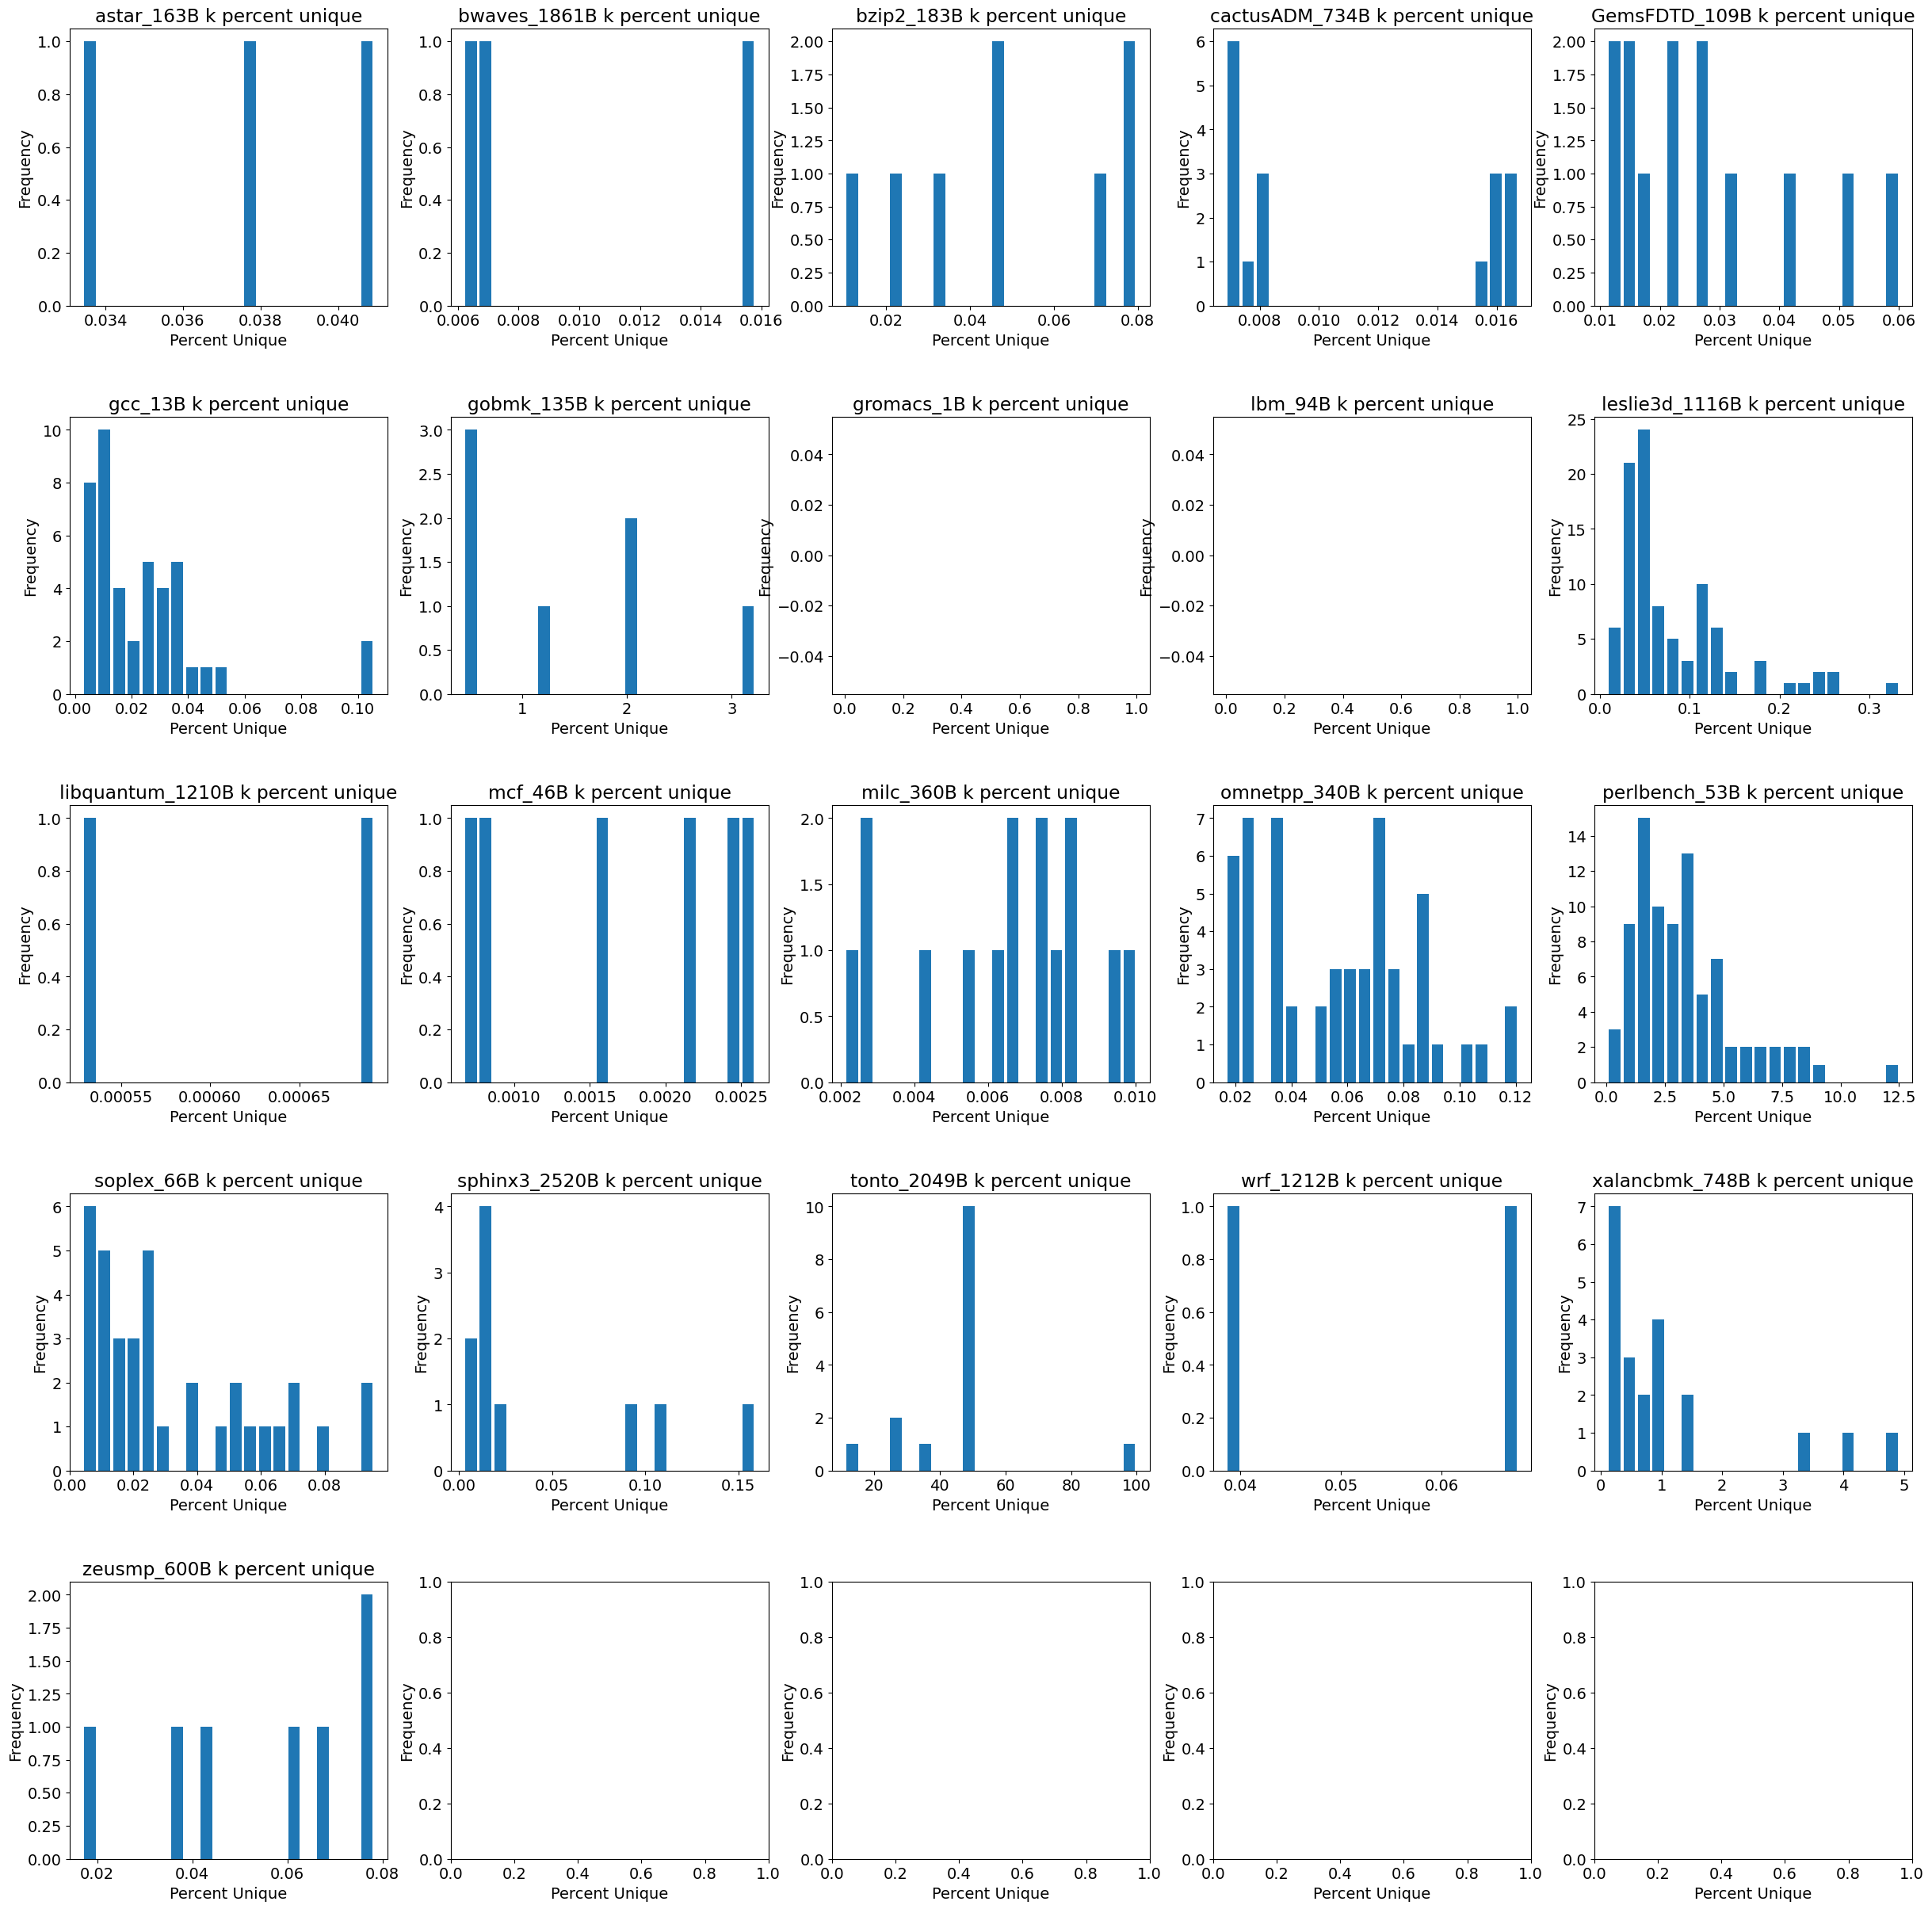

In [66]:
graph_k_percent_unique(experiment_trace_files, traces)
plt.show()

### Other Studies 

The following studies ended up showing the same things as the previous studies, just with a slight variation on calculating PC frequency. Prefetch PC frequency was only calculated for the first prefetch PC before a subsequent demand access. These studies do not provide much information that is not already known.

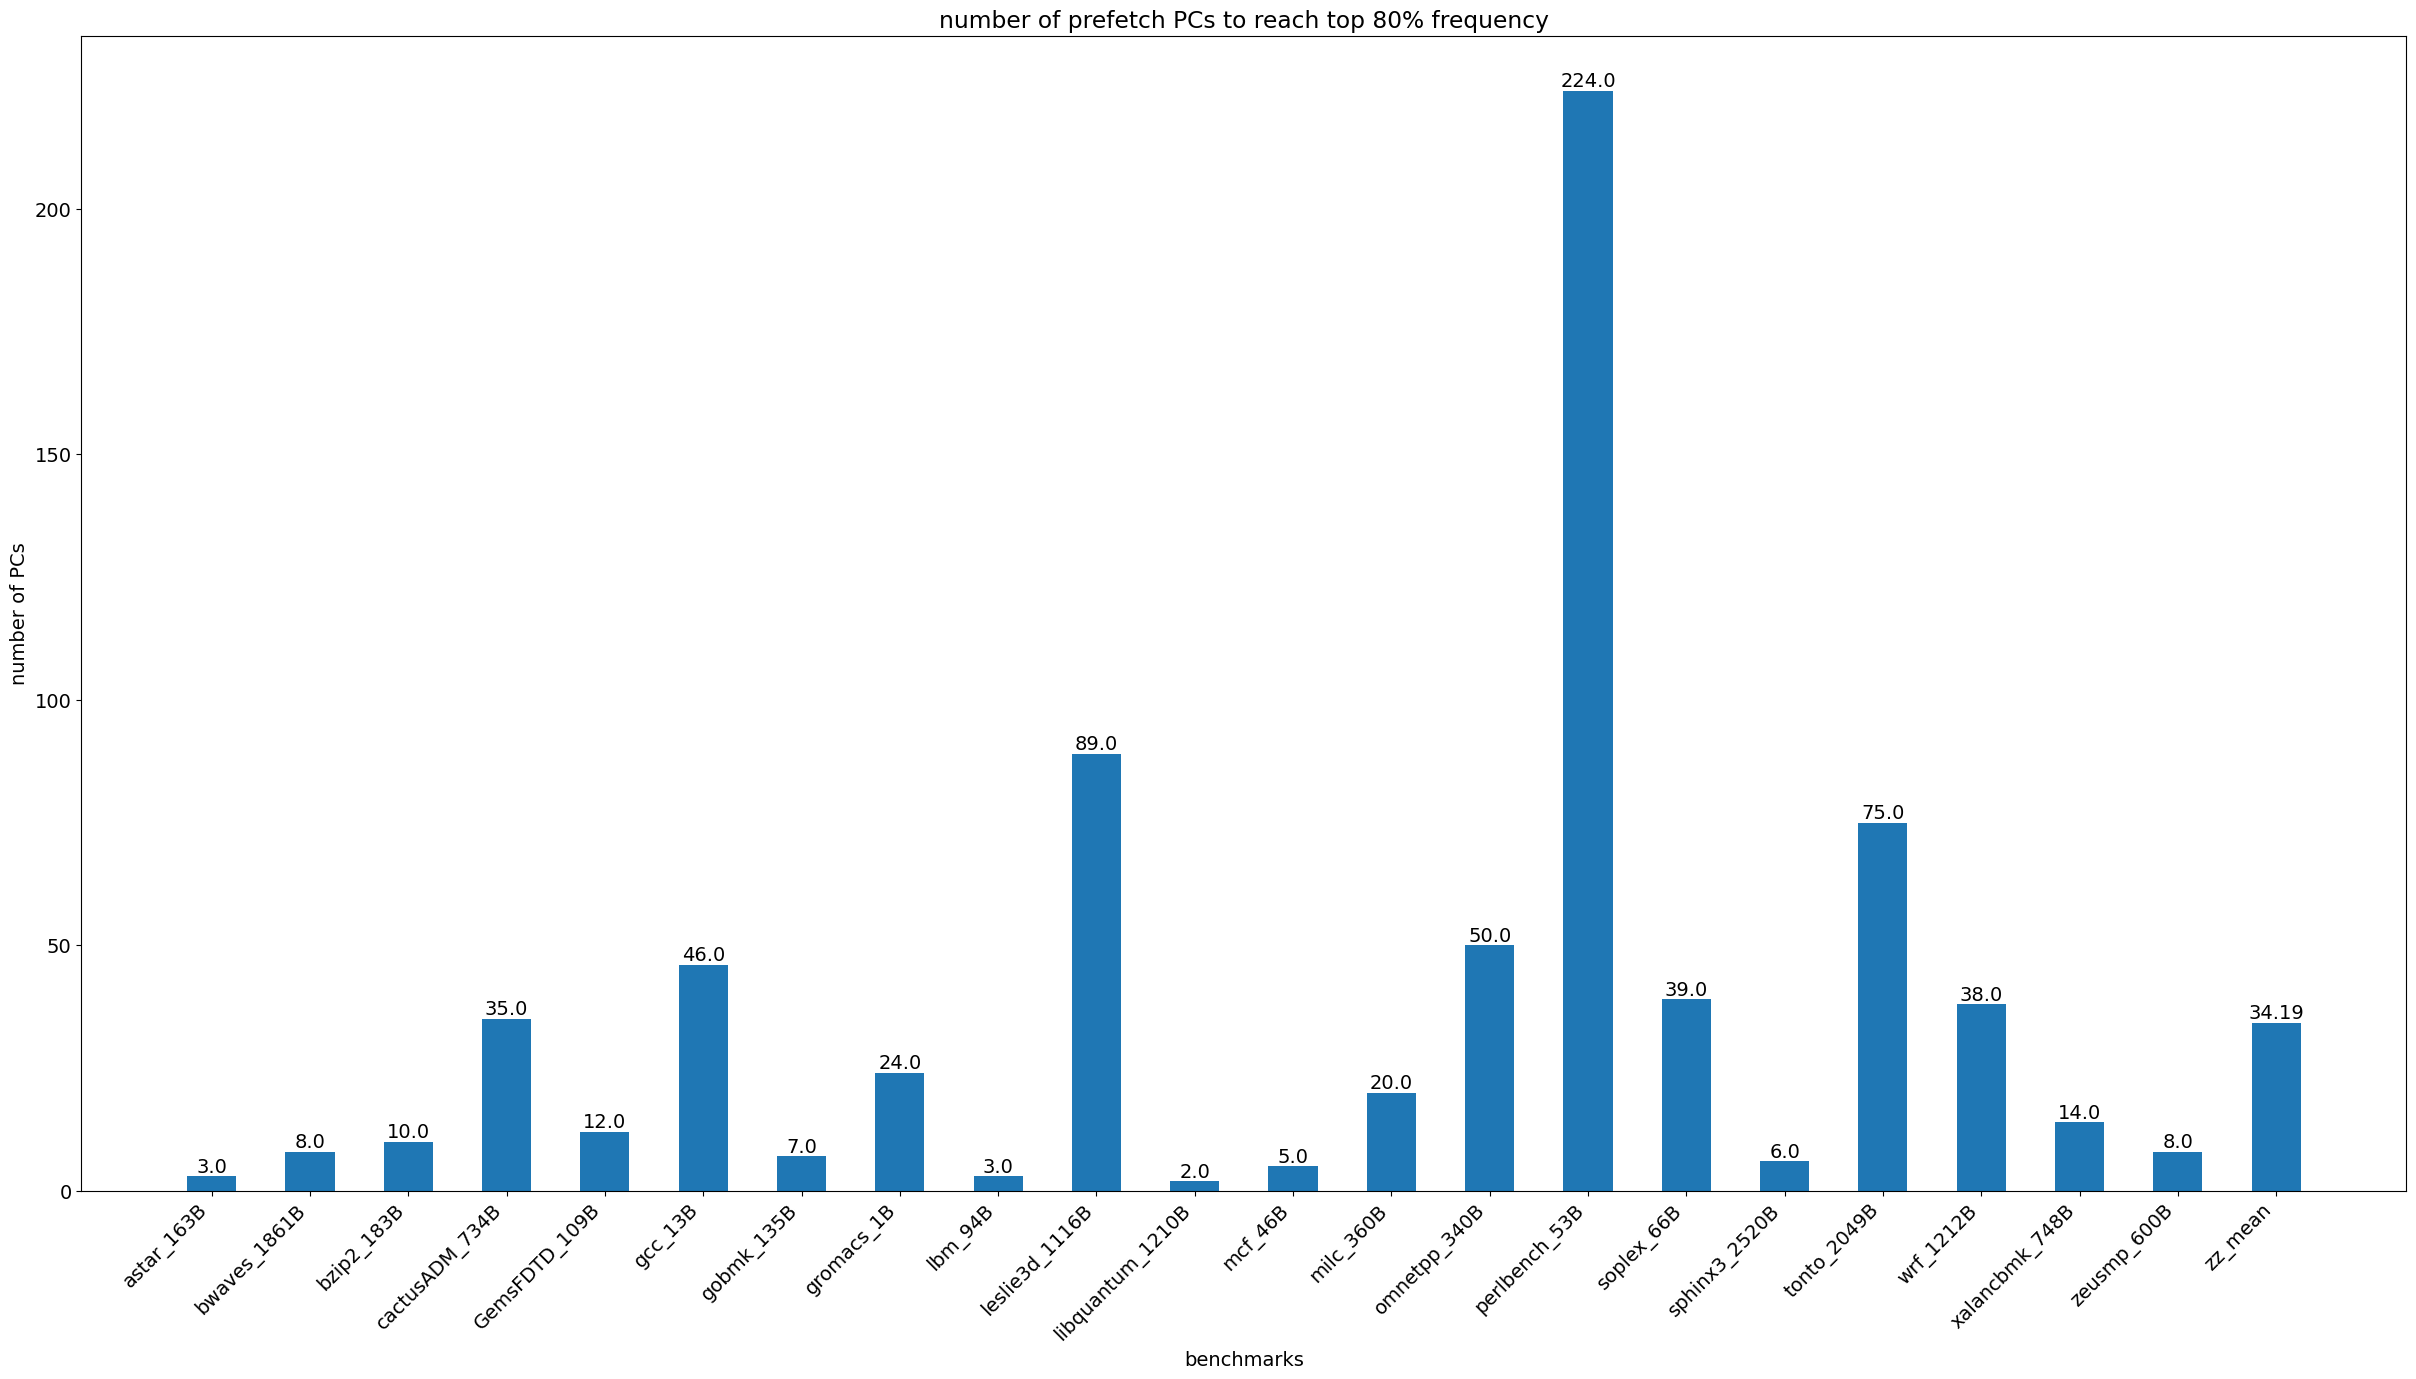

In [77]:
# Harmony with Best Offset Prefetch Interval Use
# get experiment trace files
experiment = 'experiment_tracer_hawkeye_final_dyn_bo_pc_freq_first_prefetch_only'
trace_list = open('../sim_list/traces.txt', 'r')

(experiment_trace_files, traces) = get_experiment_traces(experiment, trace_list)

graph_pc_stats(experiment_trace_files, traces)
plt.show()

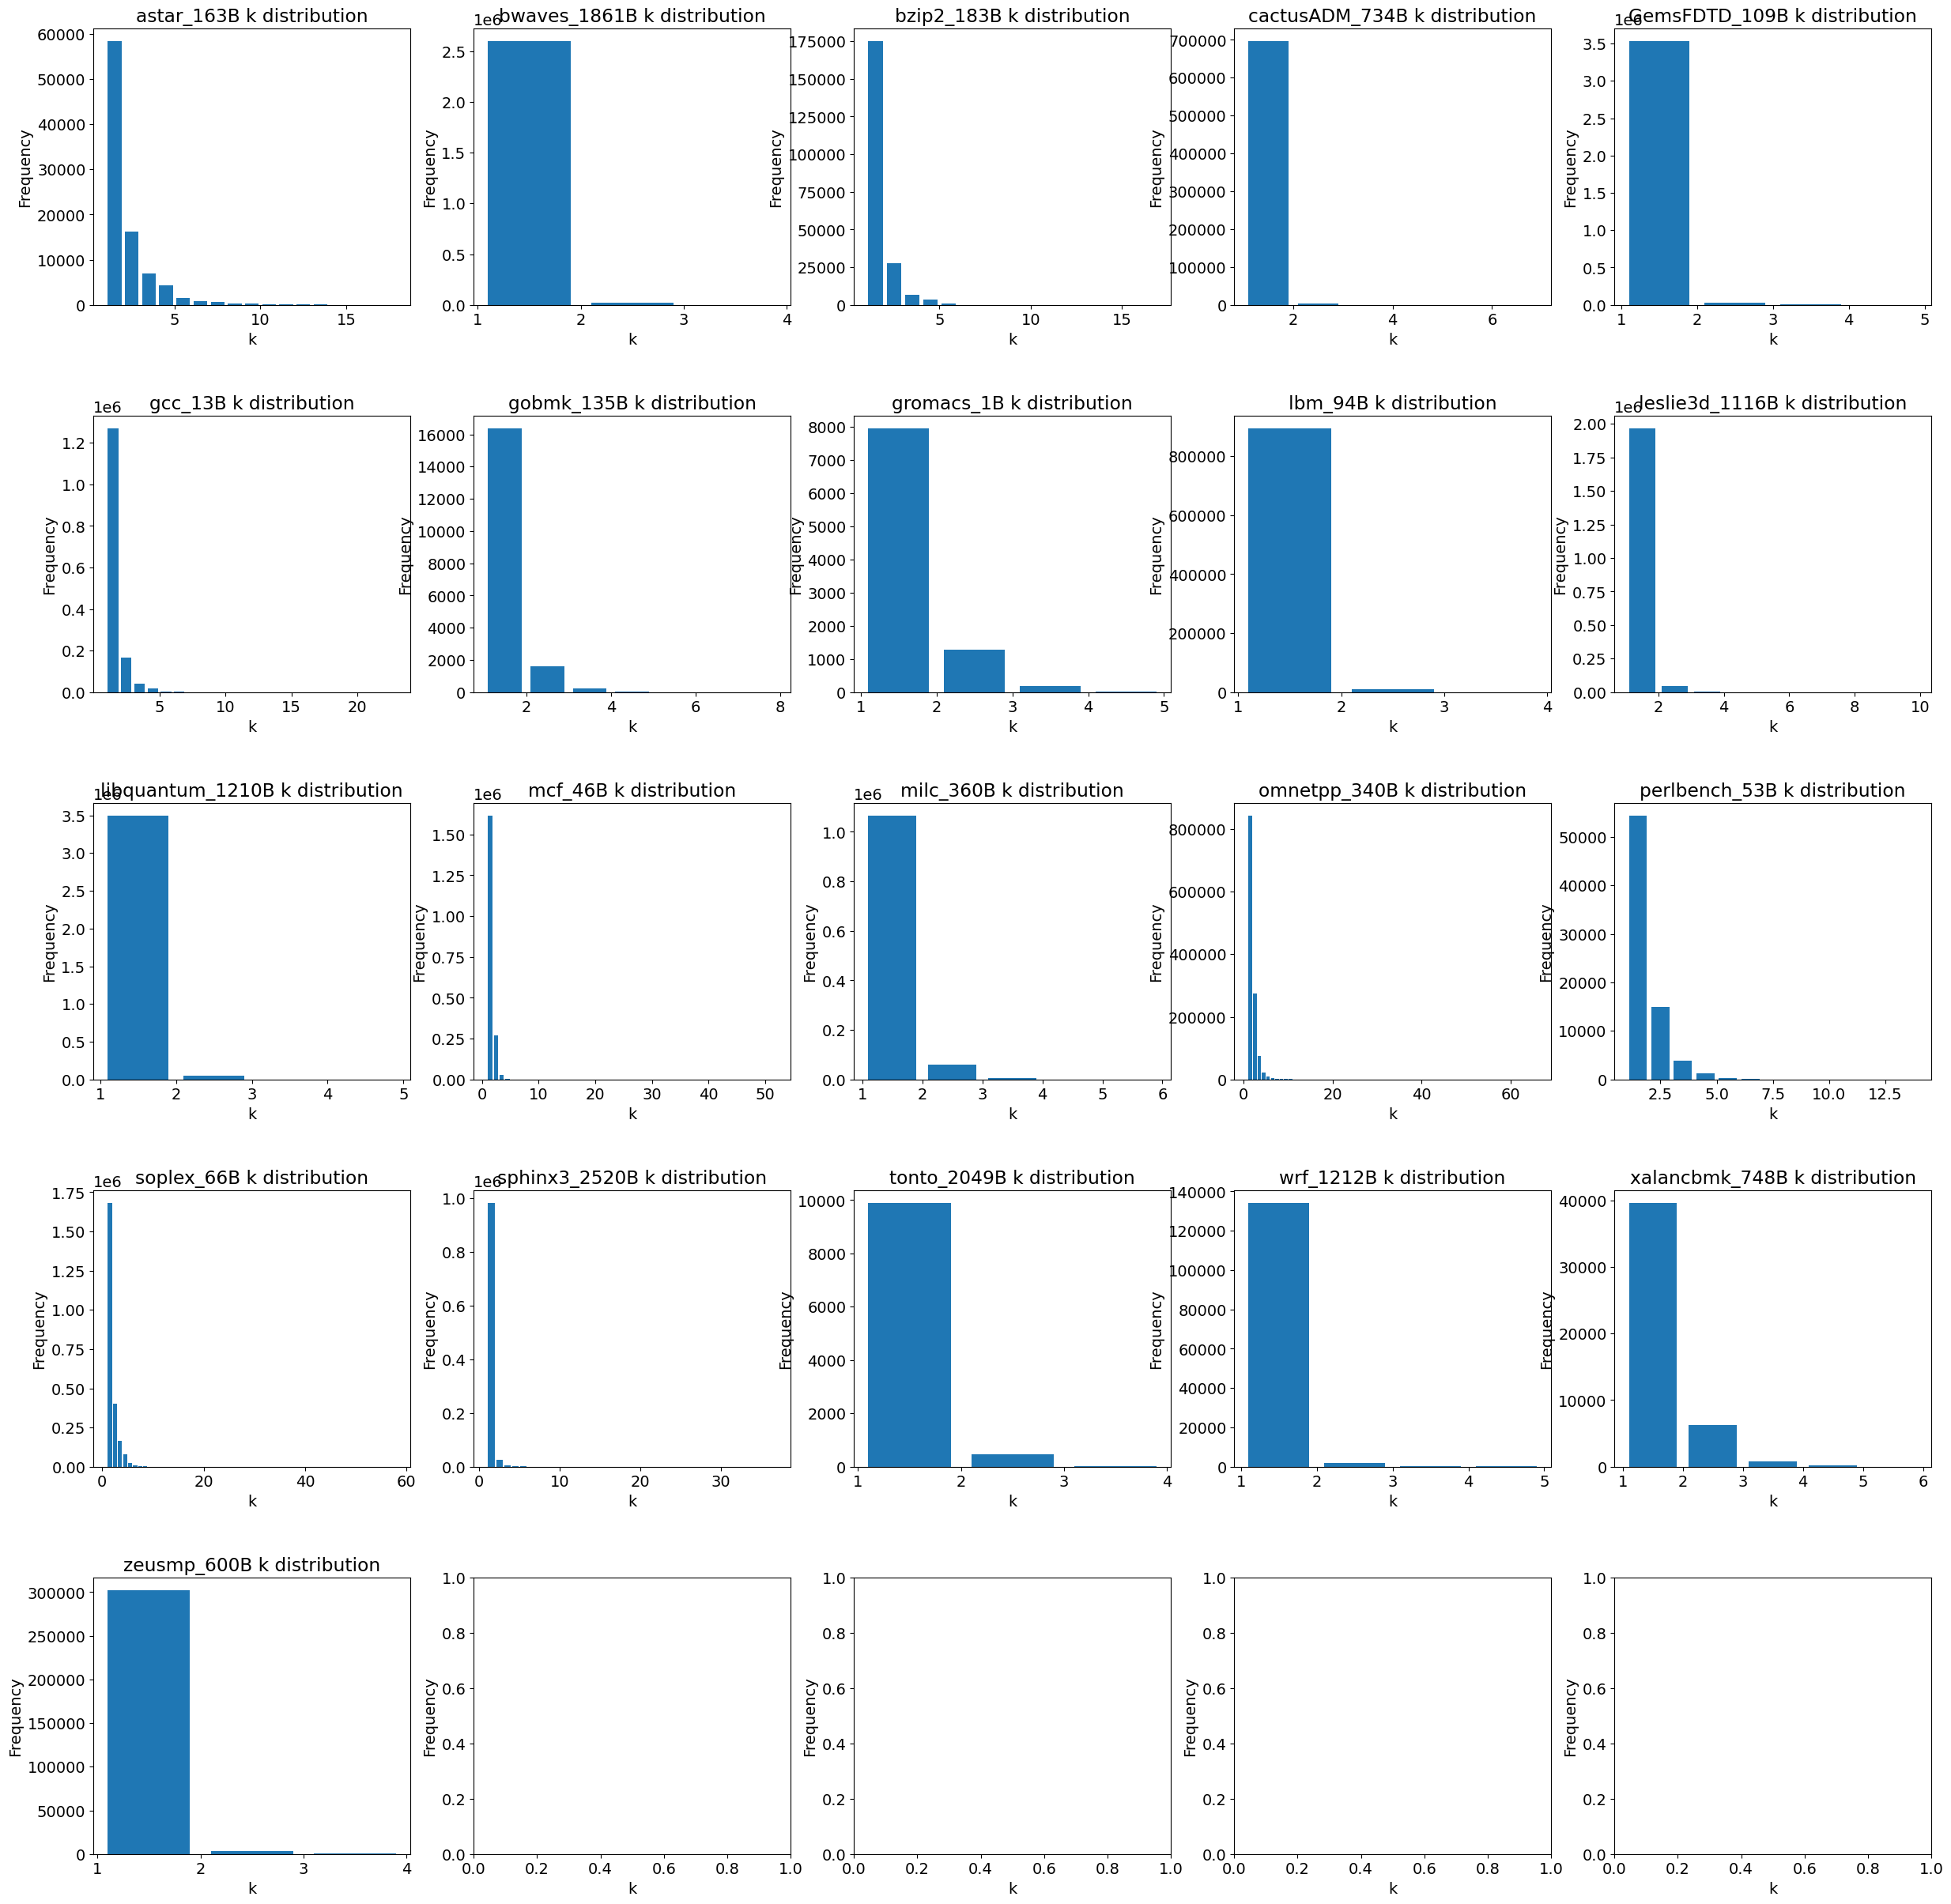

In [78]:
graph_k_distr(experiment_trace_files, traces)
plt.show()

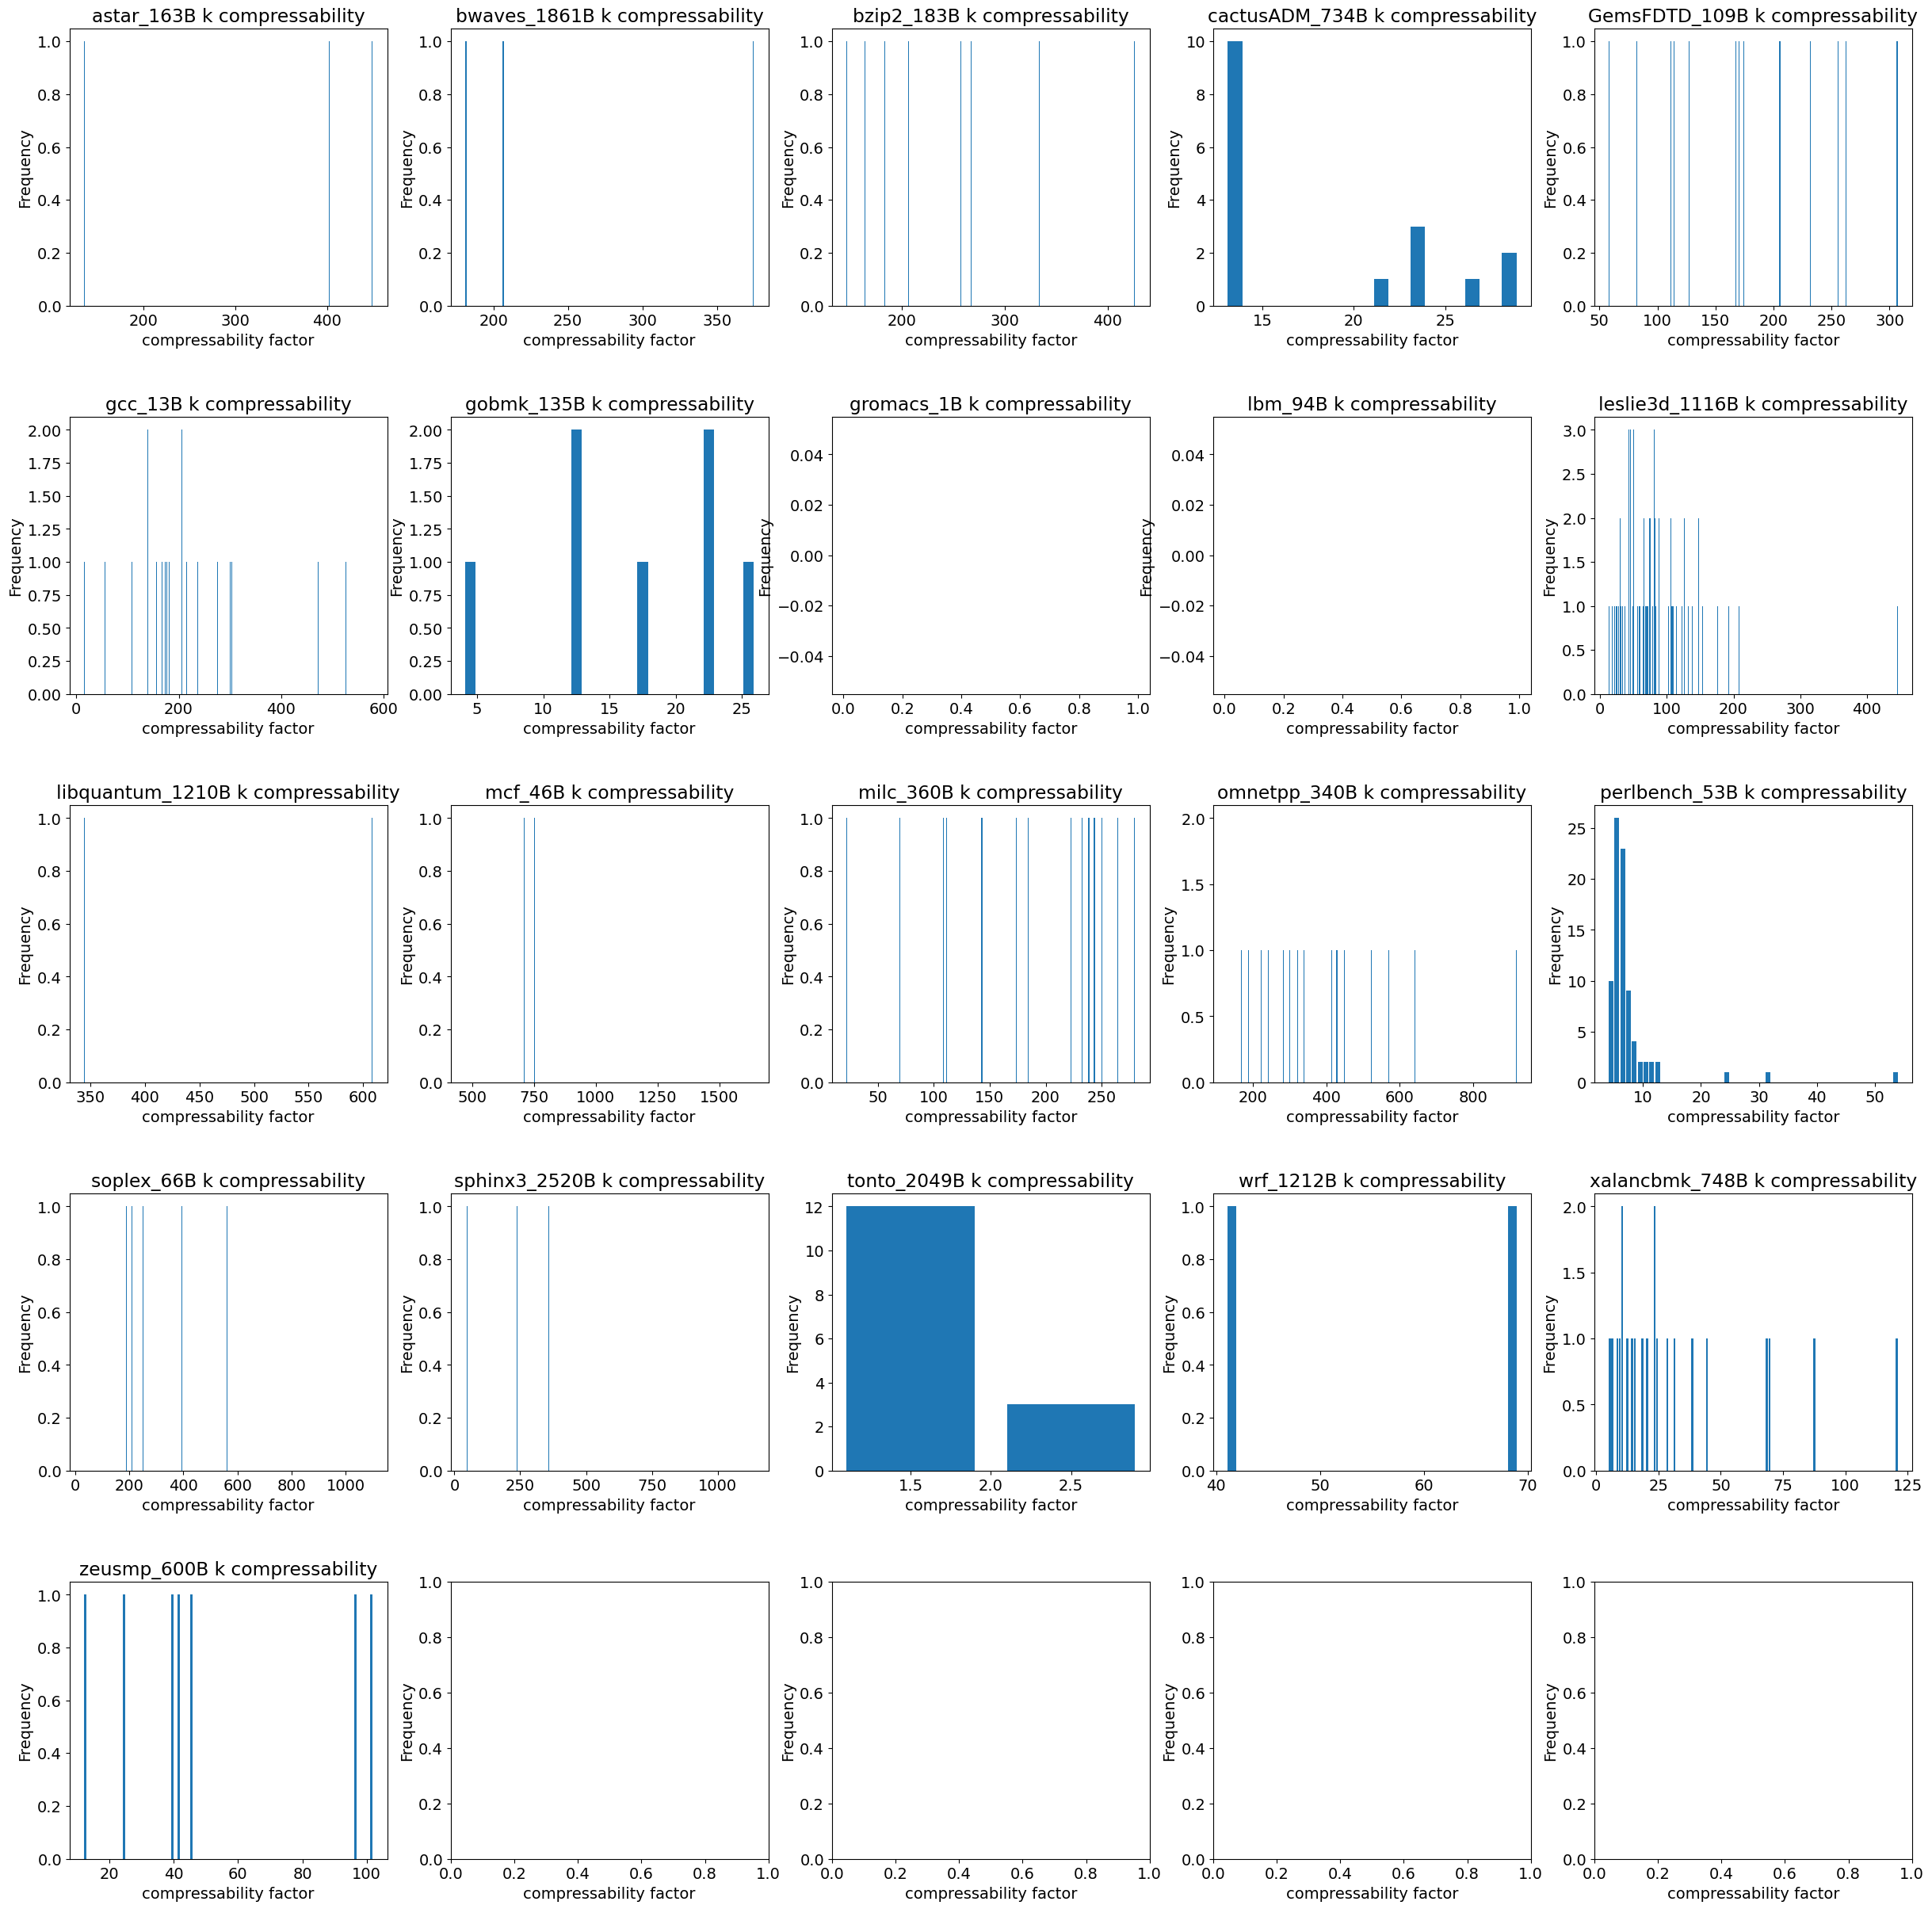

In [84]:
graph_k_compression(experiment_trace_files, traces)
plt.show()

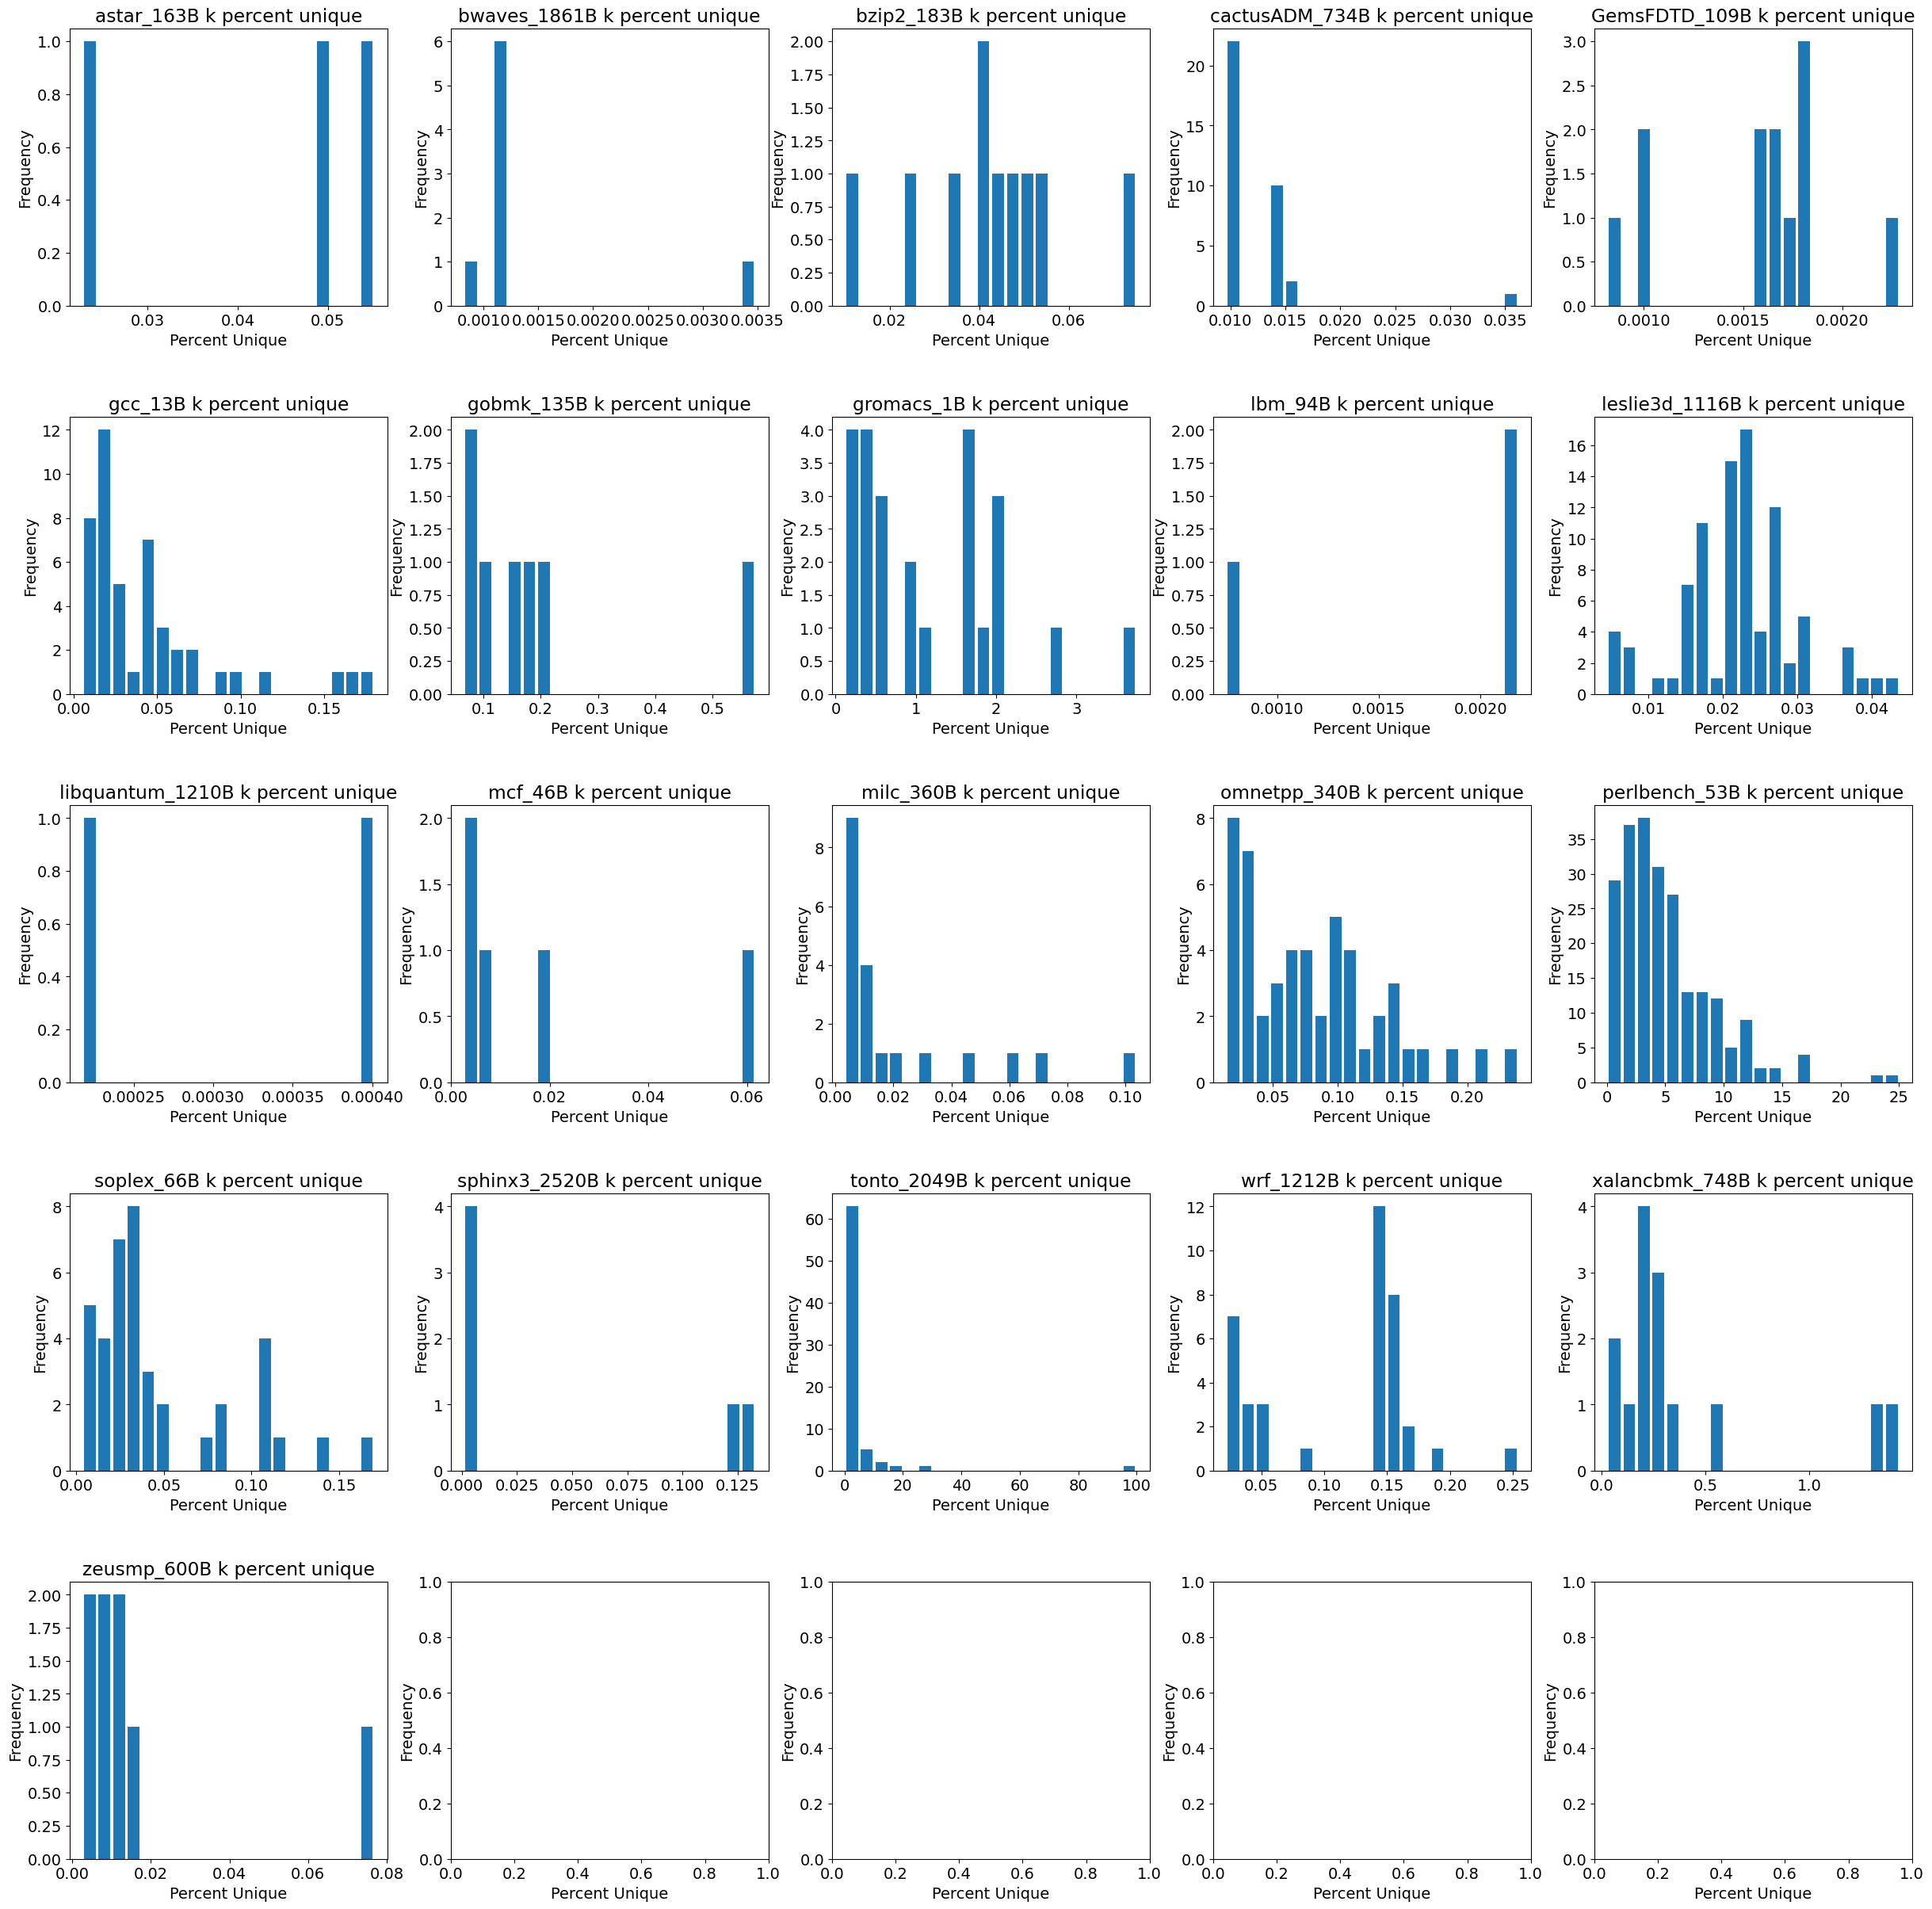

In [69]:
graph_k_percent_unique(experiment_trace_files, traces)
plt.show()

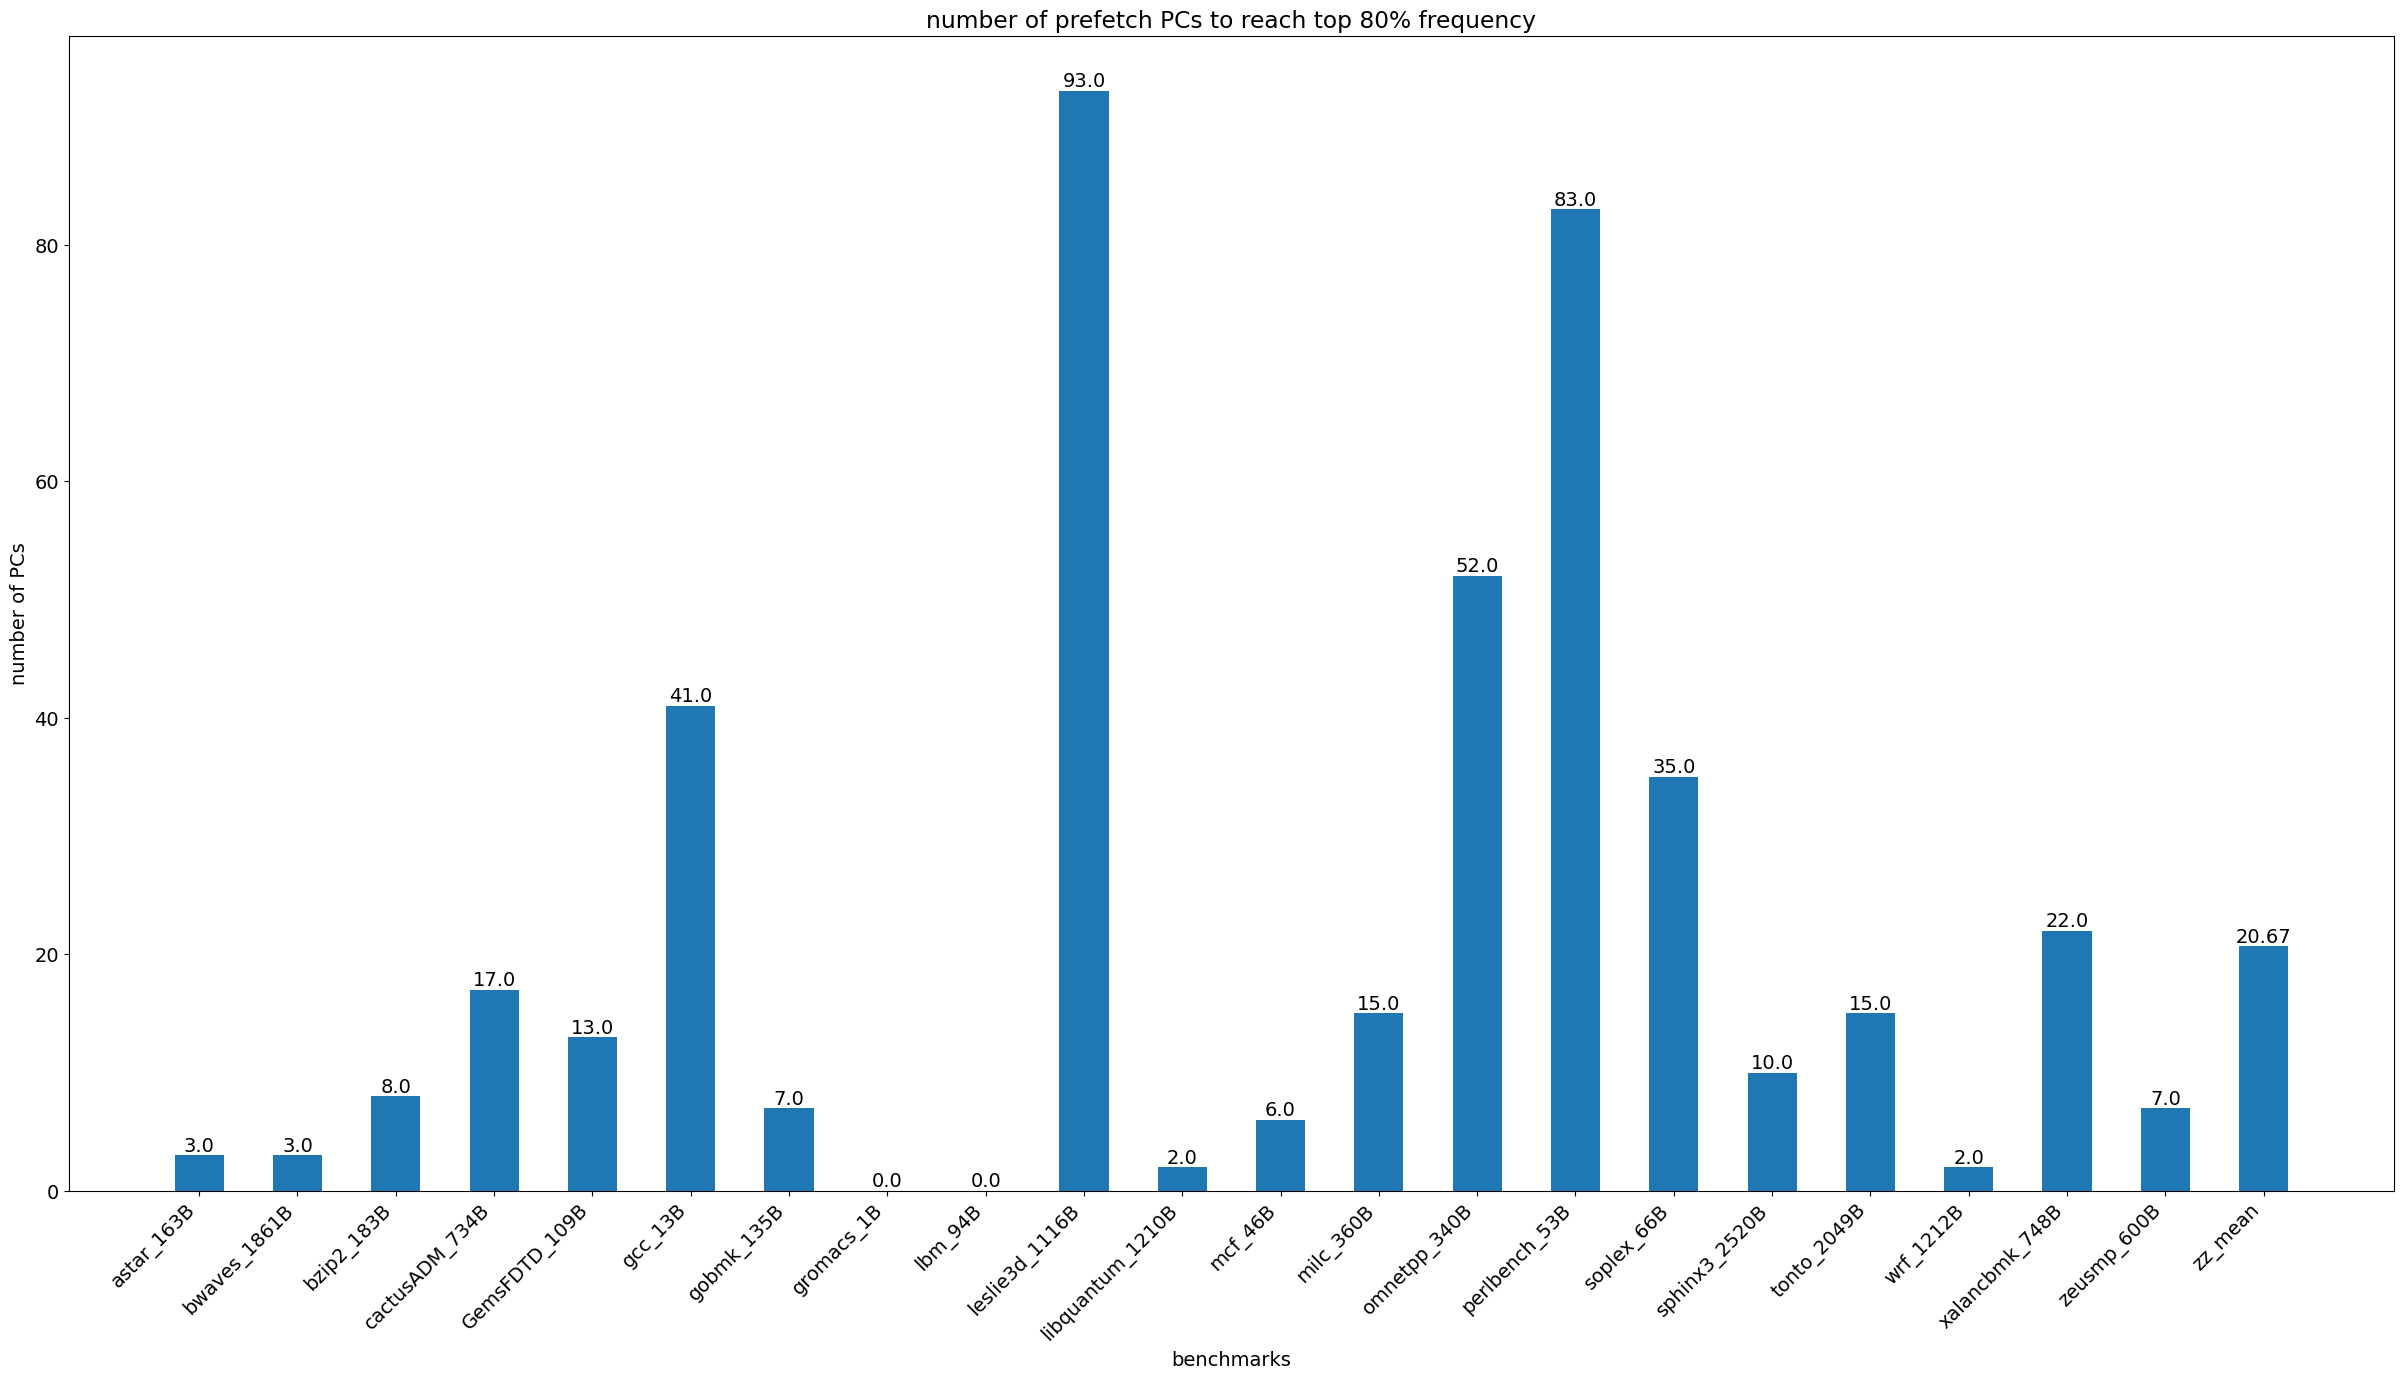

In [79]:
# Harmony with Best Offset Prefetch Interval Use
# get experiment trace files
experiment = 'experiment_tracer_hawkeye_final_dyn_isb_pc_freq_first_prefetch_only'
trace_list = open('../sim_list/traces.txt', 'r')

(experiment_trace_files, traces) = get_experiment_traces(experiment, trace_list)

graph_pc_stats(experiment_trace_files, traces)
plt.show()

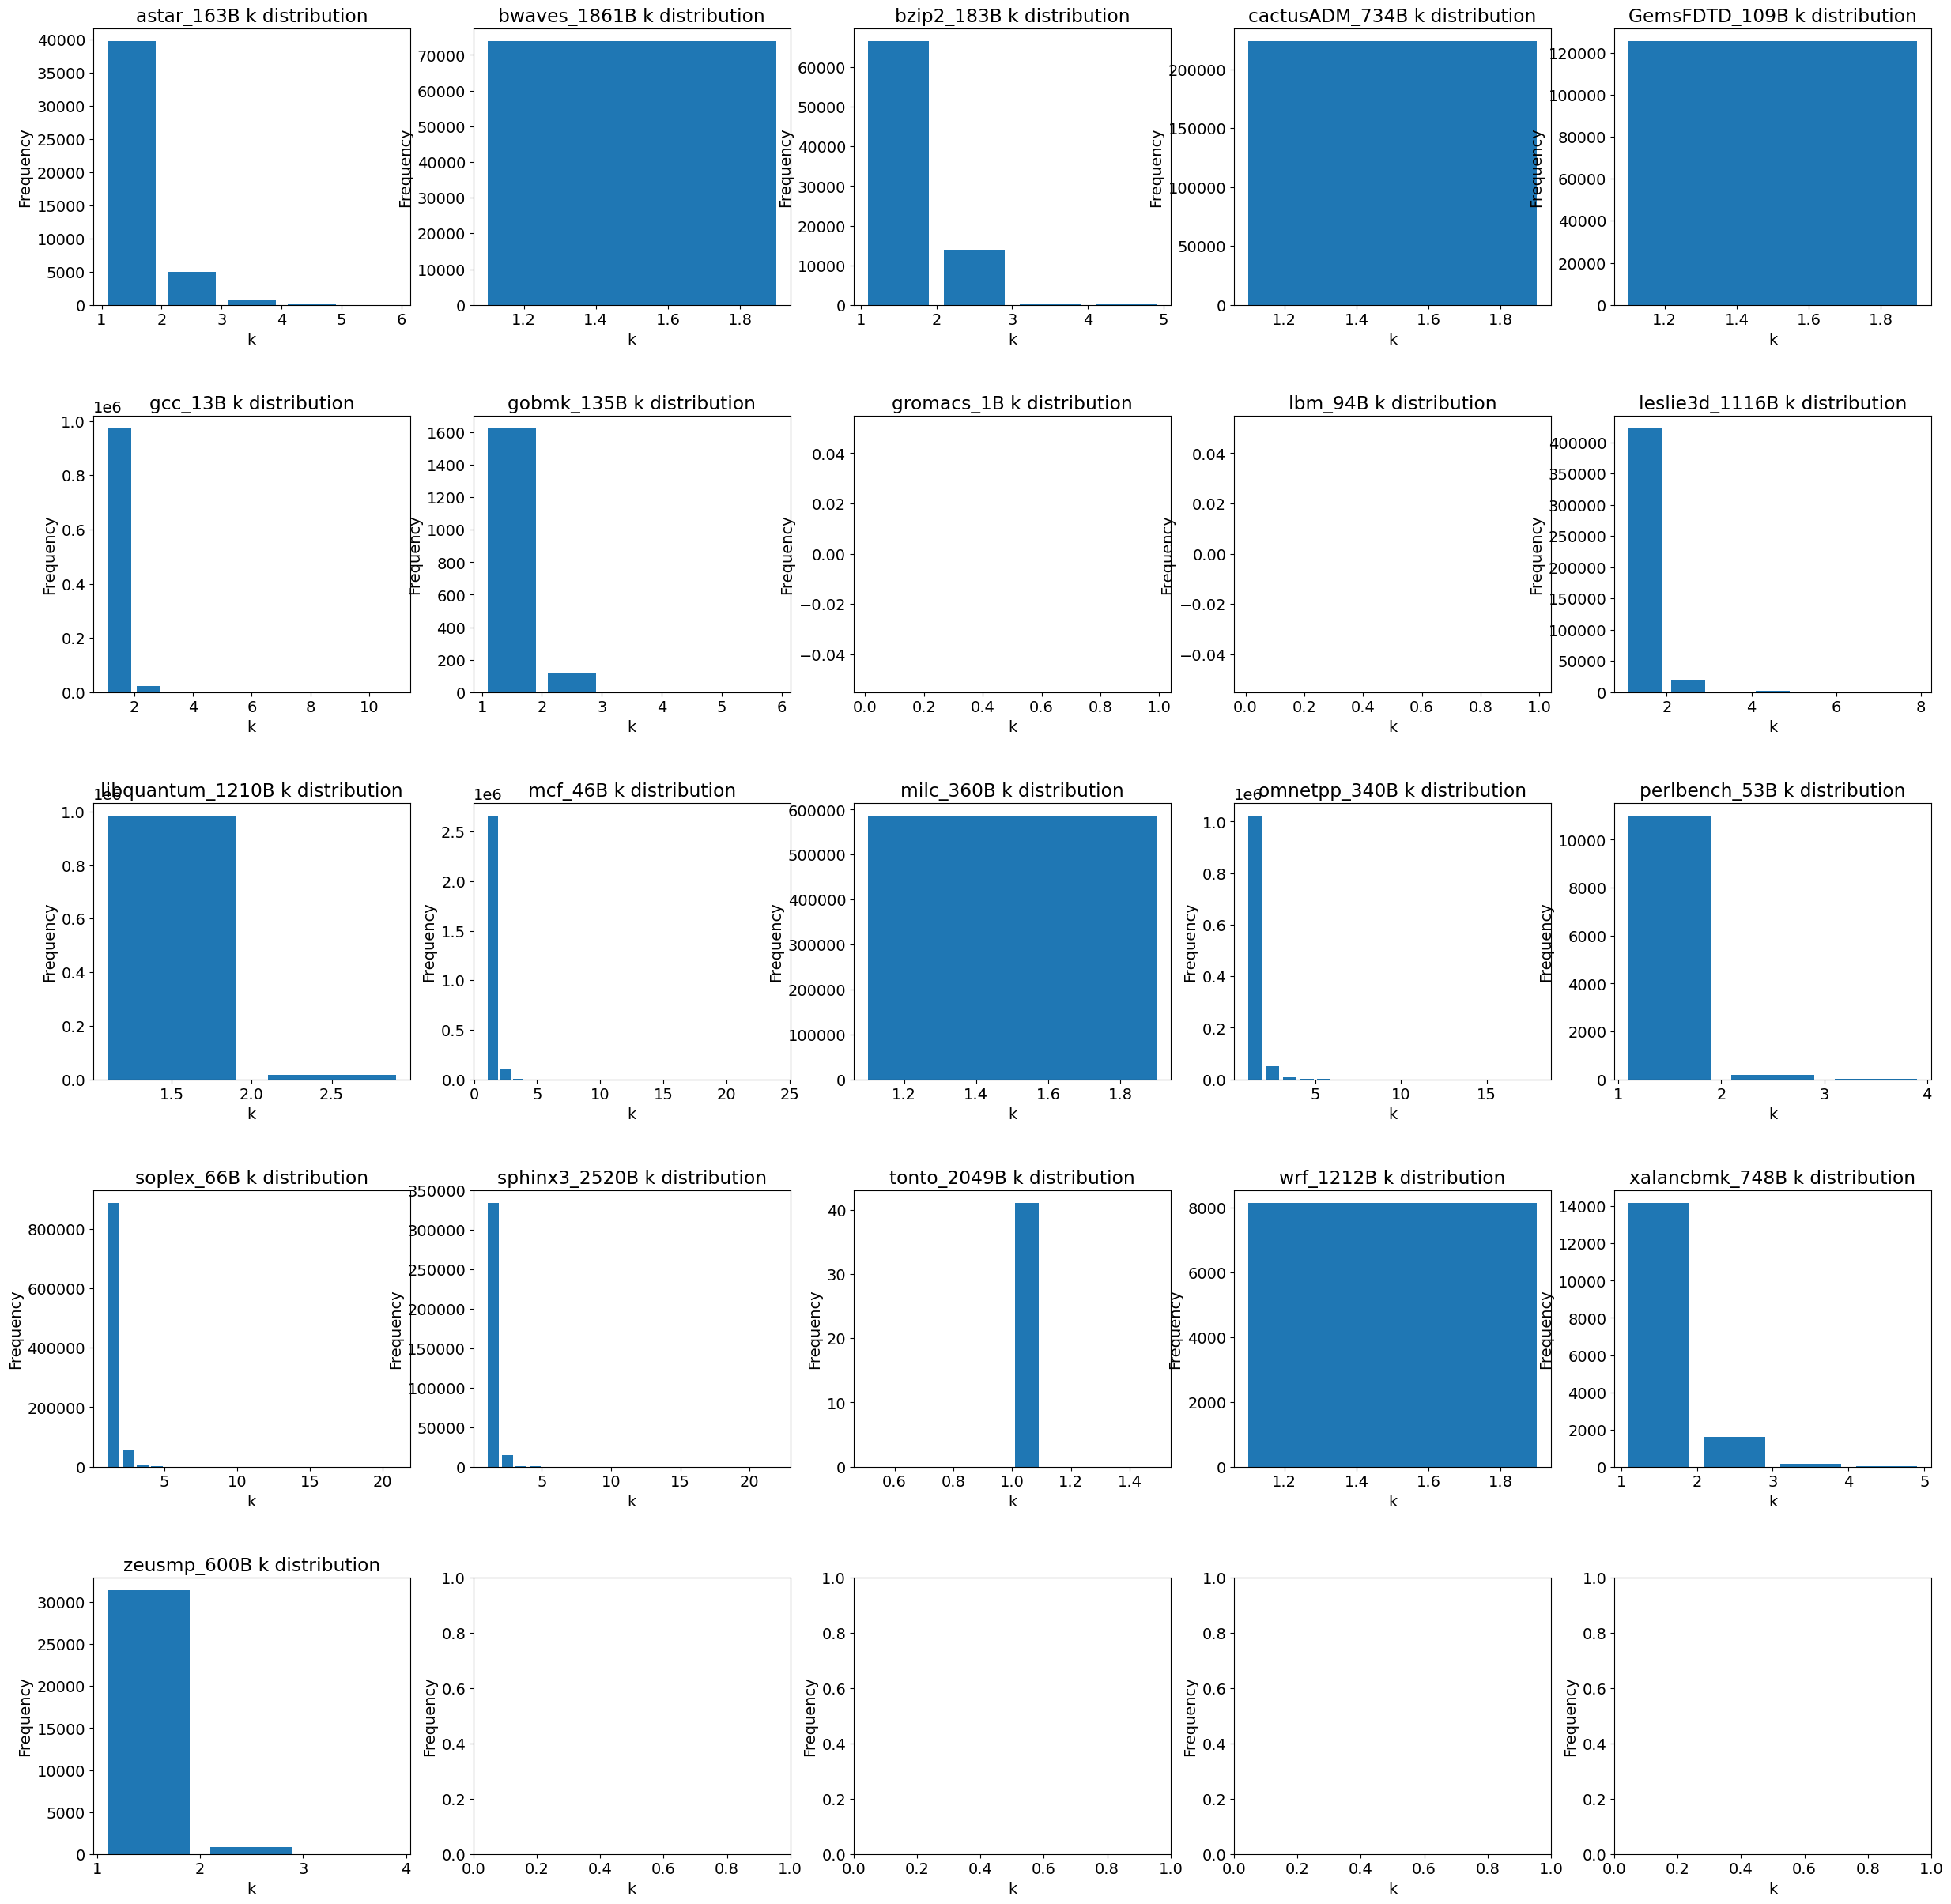

In [80]:
graph_k_distr(experiment_trace_files, traces)
plt.show()

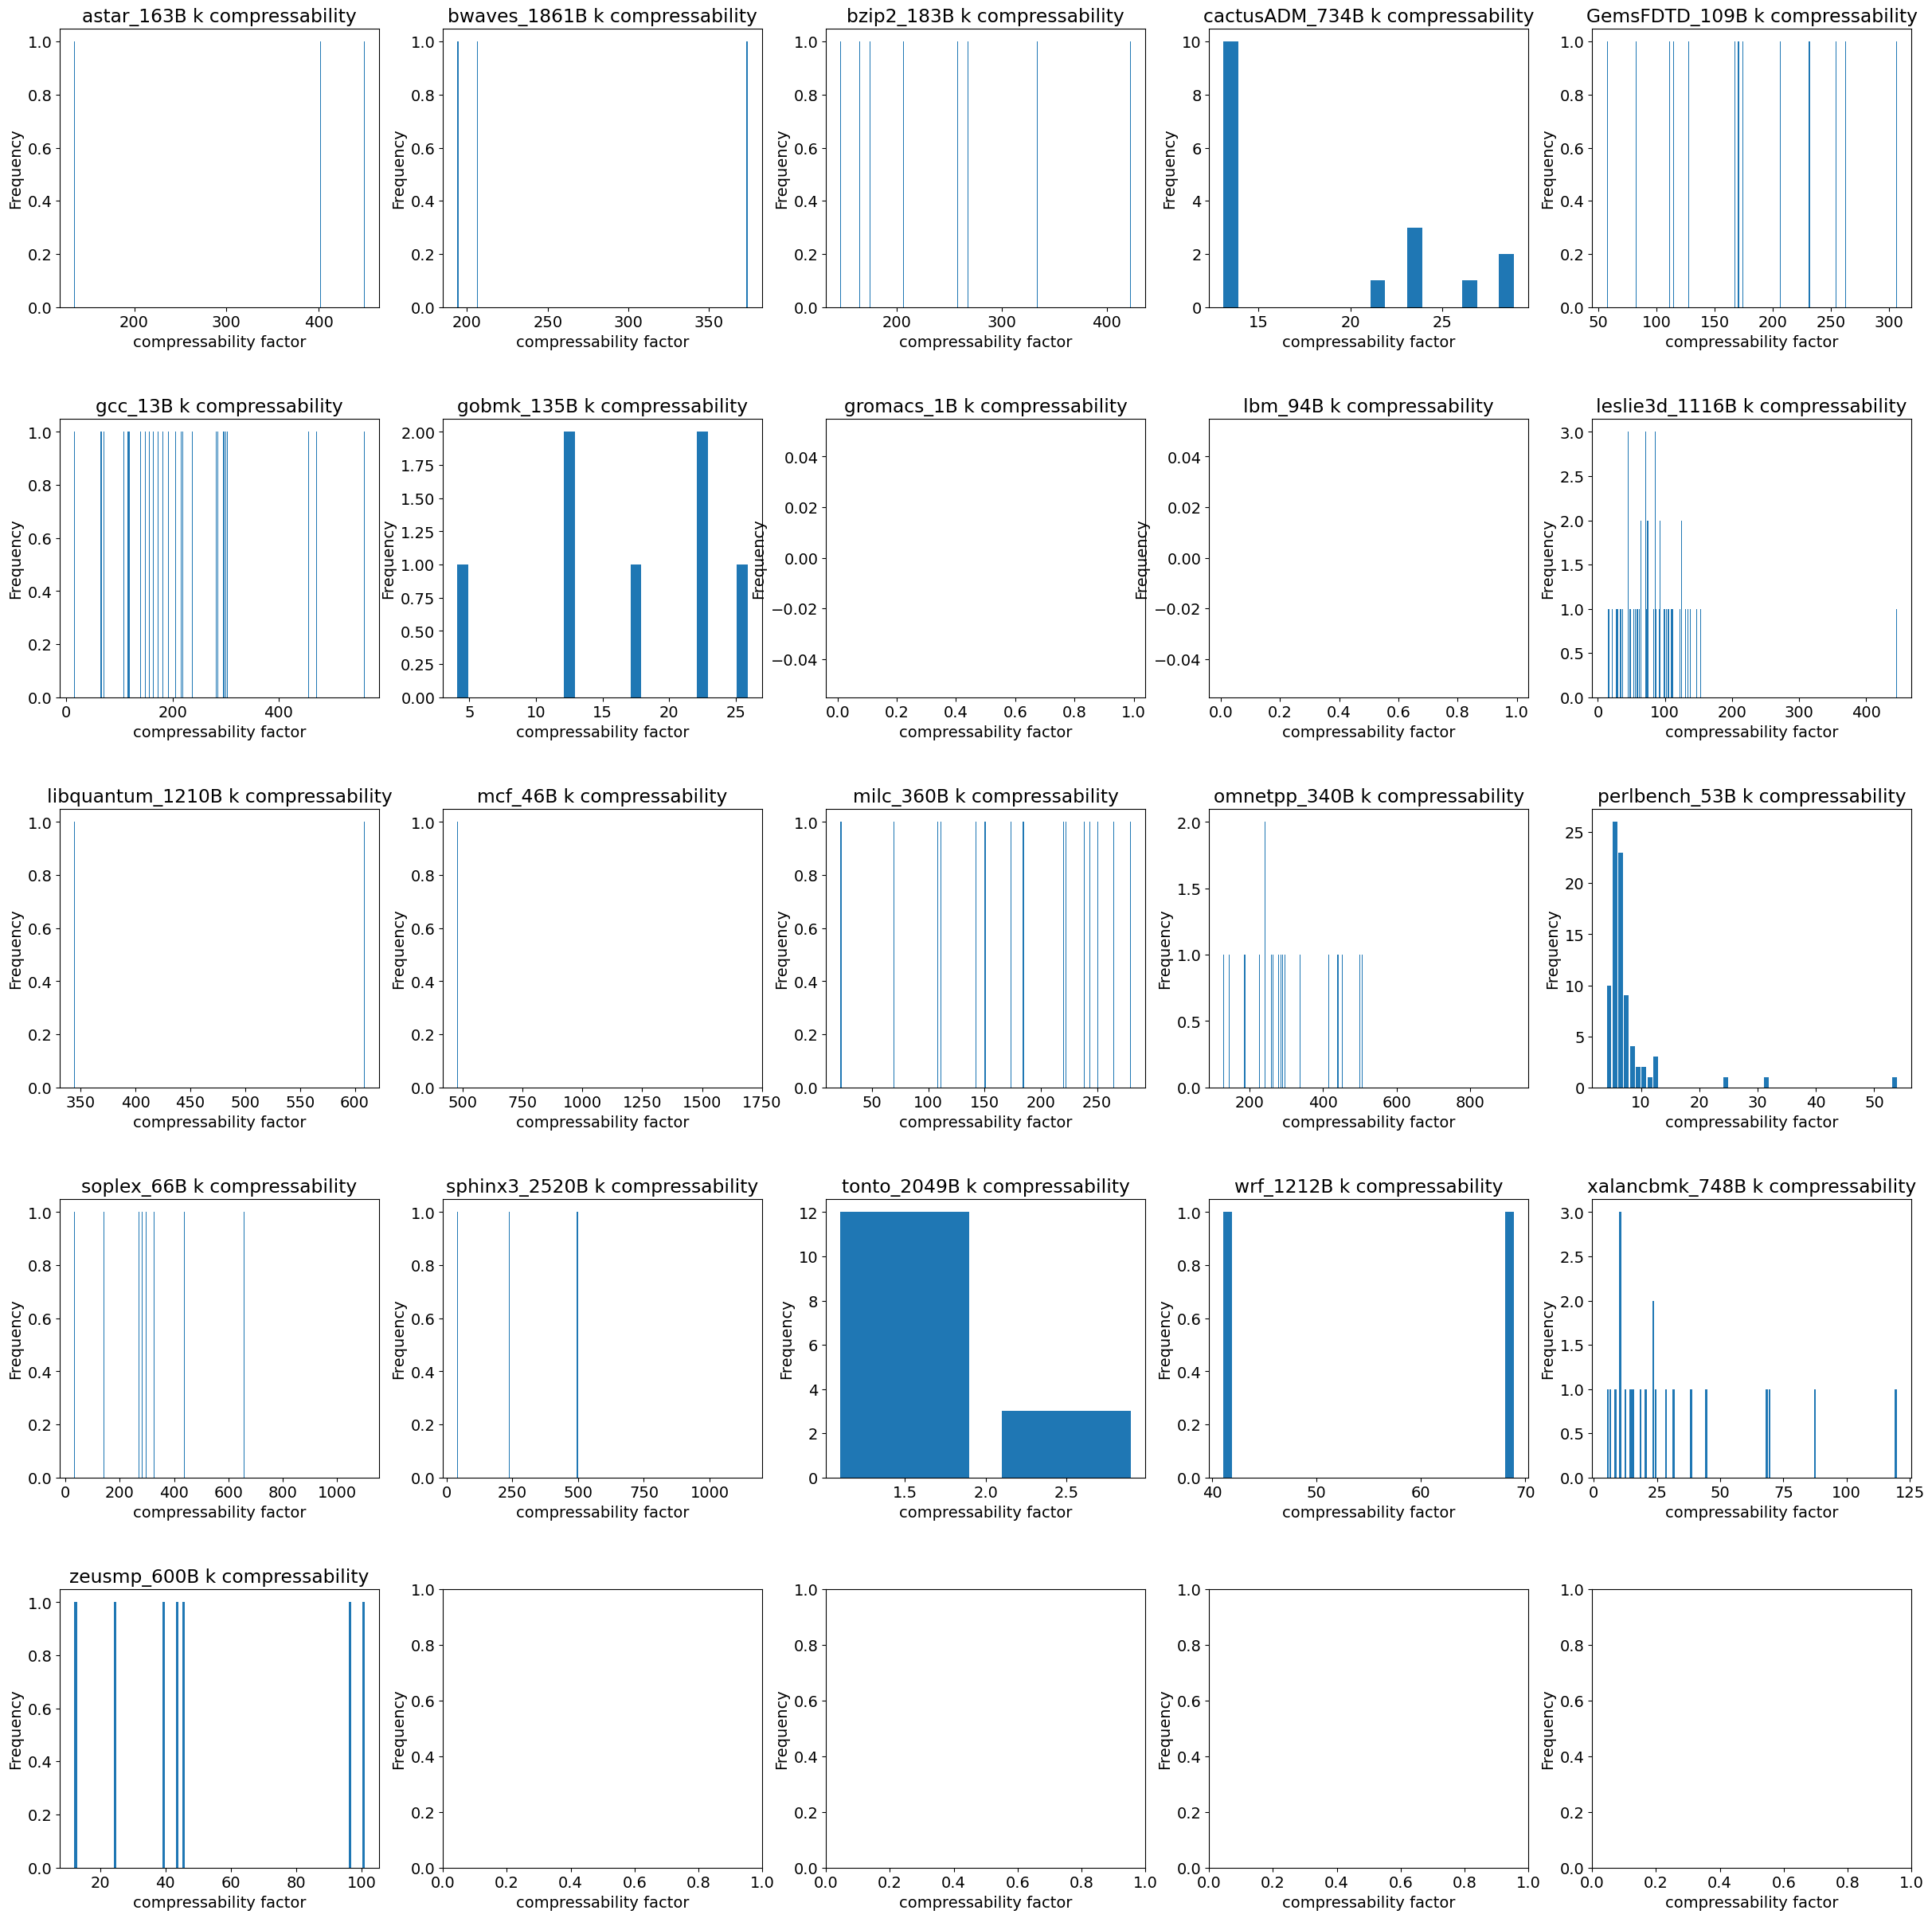

In [85]:
graph_k_compression(experiment_trace_files, traces)
plt.show()

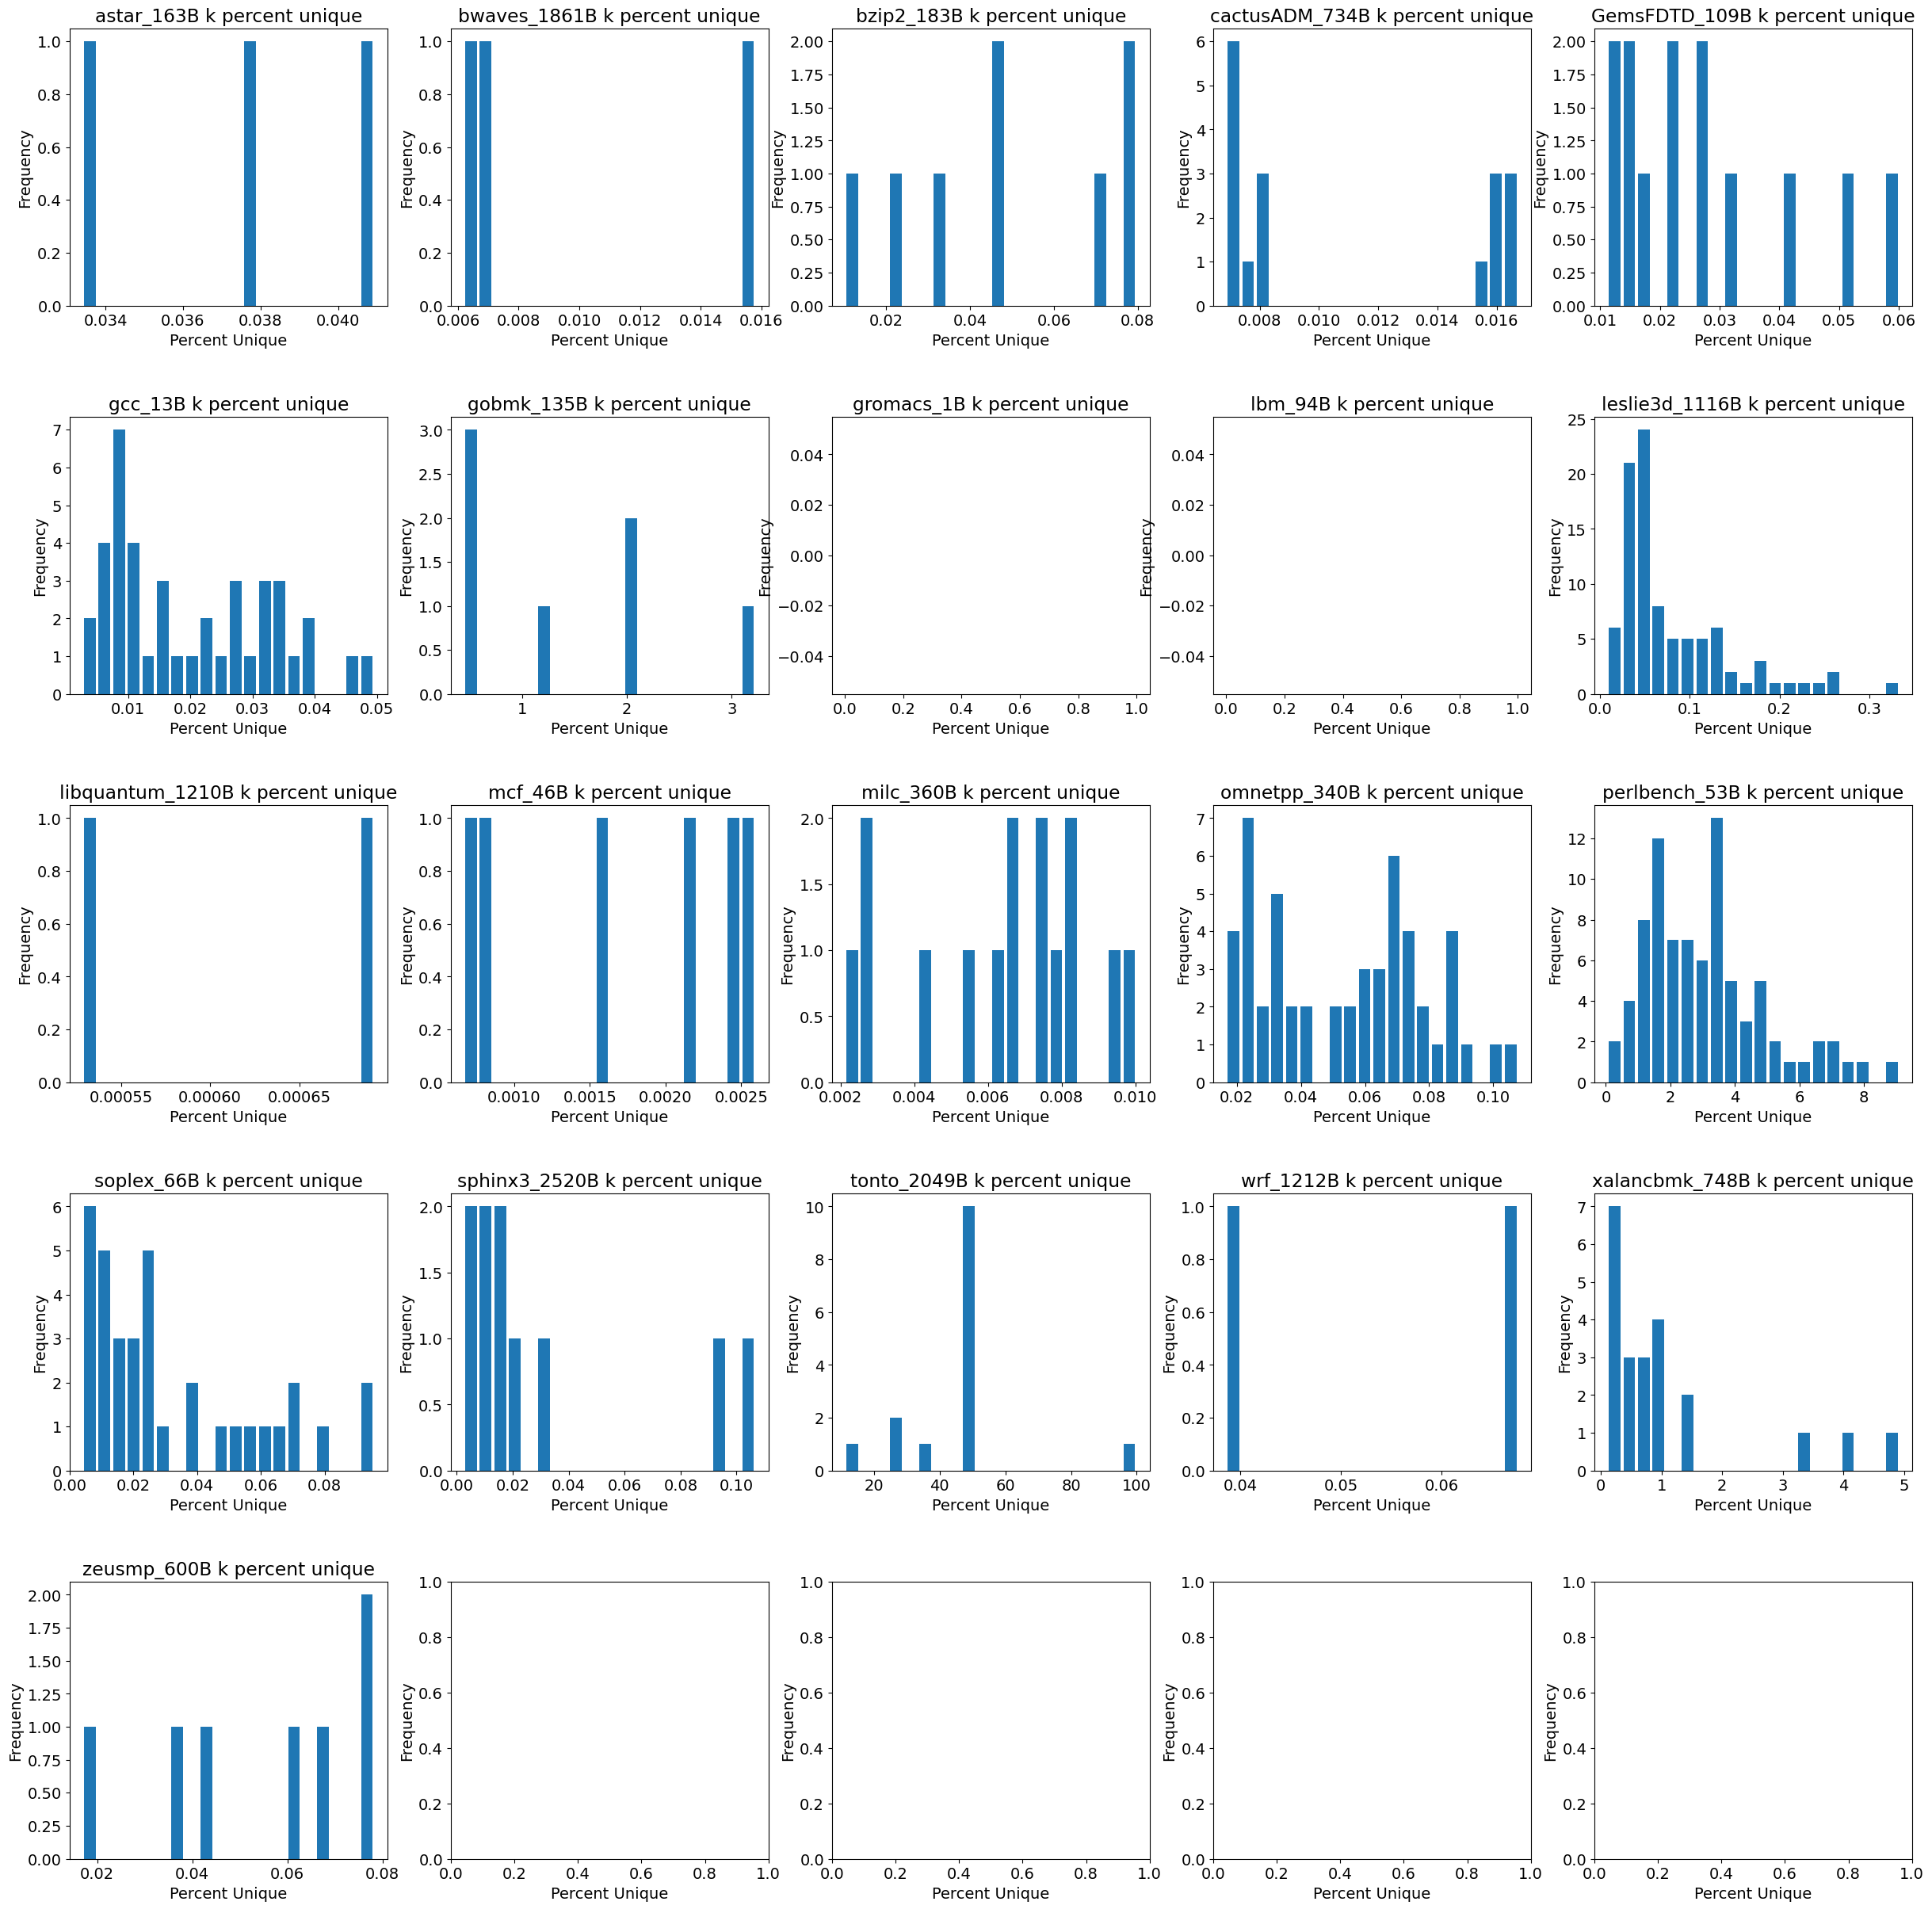

In [72]:
graph_k_percent_unique(experiment_trace_files, traces)
plt.show()